<a href="https://colab.research.google.com/github/juniperlovato/AASP/blob/main/Ai_Art_Paper_Regressions_3P.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [241]:
import numpy as np
import pandas as pd
from google.colab import files
import requests
import io
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats.contingency import odds_ratio
import matplotlib.pyplot as plt
from statsmodels.miscmodels.ordinal_model import OrderedModel
import scipy
from scipy.special import expit
from pandas.api.types import CategoricalDtype

#Data

In [242]:
#load data thats cleandd
Survey =  pd.read_csv('ai_art_surveydata_cleaned')

In [243]:
#selecting the columns I want to analyze
Survey = Survey[['Artist', 'Art_practice', 'Purchase_art',
       'Professional_artist', 'AI_models_familiarity', 'Used_AI_art_models',
       'Styleof_ownedby_AI_user', 'Styleof_ownedby_OG_artist',
       'Styleof_ownedby_AI_company', 'Required_disclosure',
       'AI_pos_development_4art', 'AI_threat_2art_workers', 'Age', 'POC',
       'Gender_identity', 'compensation']]


In [244]:
#drop nans
Survey = Survey.dropna()

In [245]:
Survey.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452 entries, 0 to 512
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Artist                      452 non-null    object 
 1   Art_practice                452 non-null    object 
 2   Purchase_art                452 non-null    object 
 3   Professional_artist         452 non-null    object 
 4   AI_models_familiarity       452 non-null    object 
 5   Used_AI_art_models          452 non-null    object 
 6   Styleof_ownedby_AI_user     452 non-null    float64
 7   Styleof_ownedby_OG_artist   452 non-null    float64
 8   Styleof_ownedby_AI_company  452 non-null    float64
 9   Required_disclosure         452 non-null    float64
 10  AI_pos_development_4art     452 non-null    float64
 11  AI_threat_2art_workers      452 non-null    float64
 12  Age                         452 non-null    object 
 13  POC                         452 non-null

#Ordinal Regression

In [246]:
#I want to one hot encode all of my independent variables
Survey = pd.get_dummies(Survey
               ,columns = ['Artist', 'Art_practice', 'Purchase_art', 'Age', 'POC',
                            'Professional_artist', 'AI_models_familiarity', 'Used_AI_art_models',
                            'Gender_identity', 'compensation']
               ,drop_first = False
               )

In [247]:
#strip whitespace from column names
Survey.rename(columns=lambda x: x.strip(), inplace=True)


In [248]:
Survey.head()

,Styleof_ownedby_AI_user,Styleof_ownedby_OG_artist,Styleof_ownedby_AI_company,Required_disclosure,AI_pos_development_4art,AI_threat_2art_workers,Artist_I’m not sure,Artist_No,Artist_Somewhat,Artist_Yes,...,compensation_Other,compensation_donate_to_trainer,compensation_flat_fee,compensation_nocomp_but_no_forprofit,compensation_nocompt_noprofit4anyone,compensation_not_comfortable_with_any_listed_options,compensation_portion_from_derivatives,compensation_portion_from_model_creators,compensation_portion_of_any_profit_made,compensation_tax
0,2.0,1.0,3.0,3.0,3.0,2.0,False,True,False,False,...,False,False,False,False,False,False,False,False,False,True
1,1.0,2.0,3.0,2.0,2.0,2.0,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
2,1.0,3.0,3.0,1.0,1.0,3.0,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
3,2.0,2.0,2.0,1.0,1.0,3.0,False,False,True,False,...,False,False,True,False,False,False,False,False,False,False
4,3.0,3.0,3.0,3.0,3.0,1.0,False,False,False,True,...,False,True,False,False,False,False,False,False,False,False


In [249]:
#Response variables

# Styleof_ownedby_AI_user
# Styleof_ownedby_OG_artist
# Styleof_ownedby_AI_company
# Required_disclosure
# AI_pos_development_4art
# AI_threat_2art_workers

In [250]:
# Explanatory Variables - categorical

Survey = Survey.rename(columns={"Artist_Yes": "Artist", "Purchase_art_Yes": "Purchased art", "POC_Yes": "Person of color",
                                "Professional_artist_Yes":"Professional artist", "Used_AI_art_models_Yes": "Used AI art models",
                                "Art_practice_Photography":"Photographer", "Art_practice_craft": "Crafter",
                                "Art_practice_designer": "Designer", "Art_practice_digital": "Digital Artist",
                               "Art_practice_drawing":"Sketch artist", "Art_practice_illustration": "Illustrator",
                                "Art_practice_maker": "Maker", "Art_practice_music": "Musician", "Art_practice_other": "Other artist",
                                "Art_practice_paint": "Painter", "Art_practice_sculpture": "Sculptor", "Art_practice_tattoo": "Tattoist",
                                "Art_practice_writing": "Writer", "AI_models_familiarity_AI art generally": "Familiarity AI art gen",
                               "AI_models_familiarity_AI_Deeplearning_GANS":"Familiarity AI/DL","AI_models_familiarity_LLMS":"Familiarity LLM",
                                "AI_models_familiarity_none": "Familiarity none", "AI_models_familiarity_text to image": "Familiarity text to image",
                                "Age_18 - 29":"Age 18-29", "Age_30-49": "Age 30-49", "Age_50-64": "Age 50-64","Age_65 or older": "Age 65 plus",
                                "Gender_identity_Female" : "Female", "Gender_identity_Male": "Male", "Gender_identity_Non-binary": "Non-binary",
                               "compensation_I_dont_need_profit": "None, don’t need profit", "compensation_Other": "Compensation Other",
                                "compensation_donate_to_trainer" :"None, donate use of artwork to train models", "compensation_flat_fee": "Flat fee",
                               "compensation_nocomp_but_no_forprofit":"None, but don’t want for-profit comp to profit", "compensation_not_comfortable_with_any_listed_options":
                                "Not comfortable with any listed", "compensation_nocompt_noprofit4anyone": "None, but don’t want anyone else to profit",
                                "compensation_portion_from_derivatives": "Portion of any profit from derivatives", "compensation_portion_from_model_creators": "Portion of any profit from model creators",
                                "compensation_portion_of_any_profit_made":"Portion of any profit", "compensation_tax": "Tax"}, errors="raise")


In [251]:
#definining the tree plots I am going to use for the odds ratio plots with 95% confidence interval bars
def treeplot(x):
  for idx, row in x.iloc[::-1].iterrows():
    ci = [[row['Odds Ratio'] - row[::-1]['2.5%']], [row['97.5%'] - row['Odds Ratio']]]
    if row['significant?'] == 'significant':
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o",
                     markersize=5, mfc="tab:red", mec="tab:red")
    else:
        plt.errorbar(x=[row['Odds Ratio']], y=[row.name], xerr=ci,
            ecolor='tab:gray', capsize=3, linestyle='None', linewidth=1, marker="o",
                     markersize=5, mfc="tab:gray", mec="tab:gray")


## Styleof_ownedby_AI_user

In [252]:
SOAU_B_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_user'],
                        Survey[['Artist', 'Purchased art', 'Person of color', 'Professional artist', 'Used AI art models',
                                ]],
                        distr='logit')

SOAU_B_res_log = SOAU_B_mod_log.fit(method='bfgs', disp=False)


# odds-ratio adjusted standard error
SOAU_B_df2plot = pd.DataFrame({
    'or': np.exp(SOAU_B_res_log.params),
    'var_diag': np.diag(SOAU_B_res_log.cov_params())
})
SOAU_B_df2plot['or_se'] = np.sqrt(SOAU_B_df2plot['or']**2 * SOAU_B_df2plot['var_diag'])
SOAU_B_df2plot = SOAU_B_df2plot.reset_index().rename(columns={'index': 'catego'})
SOAU_B_res_log.summary()

SOAU_B_params = SOAU_B_res_log.params
SOAU_B_conf = SOAU_B_res_log.conf_int()
SOAU_B_conf['Odds Ratio'] = SOAU_B_params
SOAU_B_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAU_B_odds = pd.DataFrame(np.exp(SOAU_B_conf))
# check if pvalues are significant
SOAU_B_odds['pvalues'] = SOAU_B_res_log.pvalues
SOAU_B_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAU_B_res_log.pvalues]
SOAU_B_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Artist,0.414702,1.019737,0.650297,6.081867e-02,not significant
Purchased art,0.327522,0.974205,0.564866,3.998144e-02,significant
Person of color,1.120118,2.725496,1.747248,1.389311e-02,significant
Professional artist,0.702605,1.699884,1.092862,6.935970e-01,not significant
Used AI art models,2.034051,4.377637,2.984013,2.255157e-08,significant
1.0/2.0,0.359213,1.030820,0.608510,6.473349e-02,not significant
2.0/3.0,0.759122,1.101331,0.914355,3.455775e-01,not significant


In [253]:
SOAU_GM_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_user'],
                        Survey[['Male']],
                        distr='logit')

SOAU_GM_res_log = SOAU_GM_mod_log.fit(method='bfgs', disp=False)
SOAU_GM_res_log.summary()

# odds-ratio adjusted standard error
SOAU_GM_df2plot = pd.DataFrame({
    'or': np.exp(SOAU_GM_res_log.params),
    'var_diag': np.diag(SOAU_GM_res_log.cov_params())
})
SOAU_GM_df2plot['or_se'] = np.sqrt(SOAU_GM_df2plot['or']**2 * SOAU_GM_df2plot['var_diag'])
SOAU_GM_df2plot = SOAU_GM_df2plot.reset_index().rename(columns={'index': 'catego'})
SOAU_GM_res_log.summary()

SOAU_GM_params = SOAU_GM_res_log.params
SOAU_GM_conf = SOAU_GM_res_log.conf_int()
SOAU_GM_conf['Odds Ratio'] = SOAU_GM_params
SOAU_GM_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAU_GM_odds = pd.DataFrame(np.exp(SOAU_GM_conf))
# check if pvalues are significant
SOAU_GM_odds['pvalues'] = SOAU_GM_res_log.pvalues
SOAU_GM_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAU_GM_res_log.pvalues]
SOAU_GM_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Male,1.415090,2.883435,2.019980,0.000108,significant
1.0/2.0,0.781443,1.373325,1.035942,0.806081,not significant
2.0/3.0,0.722063,1.046658,0.869340,0.139285,not significant


In [254]:
SOAU_GNM_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_user'],
                        Survey[['Female','Non-binary']],
                        distr='logit')

SOAU_GNM_res_log = SOAU_GNM_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOAU_GNM_df2plot = pd.DataFrame({
    'or': np.exp(SOAU_GNM_res_log.params),
    'var_diag': np.diag(SOAU_GNM_res_log.cov_params())
})
SOAU_GNM_df2plot['or_se'] = np.sqrt(SOAU_GNM_df2plot['or']**2 * SOAU_GNM_df2plot['var_diag'])
SOAU_GNM_df2plot = SOAU_GNM_df2plot.reset_index().rename(columns={'index': 'catego'})
SOAU_GNM_res_log.summary()

SOAU_GNM_params = SOAU_GNM_res_log.params
SOAU_GNM_conf = SOAU_GNM_res_log.conf_int()
SOAU_GNM_conf['Odds Ratio'] = SOAU_GNM_params
SOAU_GNM_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAU_GNM_odds = pd.DataFrame(np.exp(SOAU_GNM_conf))
# check if pvalues are significant
SOAU_GNM_odds['pvalues'] = SOAU_GNM_res_log.pvalues
SOAU_GNM_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAU_GNM_res_log.pvalues]
SOAU_GNM_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Female,0.314178,0.661740,0.455965,3.585869e-05,significant
Non-binary,0.389118,1.943853,0.869706,7.337073e-01,not significant
1.0/2.0,0.402171,0.651067,0.511703,4.982398e-08,significant
2.0/3.0,0.725206,1.051290,0.873156,1.521613e-01,not significant


In [255]:
SOAU_AgeO_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_user'],
                        Survey[['Age 50-64','Age 65 plus']],
                        distr='logit')

SOAU_AgeO_res_log = SOAU_AgeO_mod_log.fit(method='bfgs', disp=False)


# odds-ratio adjusted standard error
SOAU_AgeO_df2plot = pd.DataFrame({
    'or': np.exp(SOAU_AgeO_res_log.params),
    'var_diag': np.diag(SOAU_AgeO_res_log.cov_params())
})
SOAU_AgeO_df2plot['or_se'] = np.sqrt(SOAU_AgeO_df2plot['or']**2 * SOAU_AgeO_df2plot['var_diag'])
SOAU_AgeO_df2plot = SOAU_AgeO_df2plot.reset_index().rename(columns={'index': 'catego'})
SOAU_AgeO_res_log.summary()

SOAU_AgeO_params = SOAU_AgeO_res_log.params
SOAU_AgeO_conf = SOAU_AgeO_res_log.conf_int()
SOAU_AgeO_conf['Odds Ratio'] = SOAU_AgeO_params
SOAU_AgeO_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAU_AgeO_odds = pd.DataFrame(np.exp(SOAU_AgeO_conf))
# check if pvalues are significant
SOAU_AgeO_odds['pvalues'] = SOAU_AgeO_res_log.pvalues
SOAU_AgeO_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAU_AgeO_res_log.pvalues]
SOAU_AgeO_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Age 50-64,0.698376,1.745508,1.104093,0.671752,not significant
Age 65 plus,0.352683,1.146873,0.635990,0.132472,not significant
1.0/2.0,0.537381,0.827242,0.666742,0.000230,significant
2.0/3.0,0.705297,1.021810,0.848929,0.083306,not significant


In [256]:
SOAU_AgeY_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_user'],
                        Survey[['Age 18-29','Age 30-49']],
                        distr='logit')

SOAU_AgeY_res_log = SOAU_AgeY_mod_log.fit(method='bfgs', disp=False)
SOAU_AgeY_res_log.summary()

# odds-ratio adjusted standard error
SOAU_AgeY_df2plot = pd.DataFrame({
    'or': np.exp(SOAU_AgeY_res_log.params),
    'var_diag': np.diag(SOAU_AgeY_res_log.cov_params())
})
SOAU_AgeY_df2plot['or_se'] = np.sqrt(SOAU_AgeY_df2plot['or']**2 * SOAU_AgeY_df2plot['var_diag'])
SOAU_AgeY_df2plot = SOAU_AgeY_df2plot.reset_index().rename(columns={'index': 'catego'})
SOAU_AgeY_res_log.summary()

SOAU_AgeY_params = SOAU_AgeY_res_log.params
SOAU_AgeY_conf = SOAU_AgeY_res_log.conf_int()
SOAU_AgeY_conf['Odds Ratio'] = SOAU_AgeY_params
SOAU_AgeY_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAU_AgeY_odds = pd.DataFrame(np.exp(SOAU_AgeY_conf))
# check if pvalues are significant
SOAU_AgeY_odds['pvalues'] = SOAU_AgeY_res_log.pvalues
SOAU_AgeY_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAU_AgeY_res_log.pvalues]
SOAU_AgeY_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Age 18-29,0.570787,1.525004,0.932980,0.782005,not significant
Age 30-49,0.791308,1.788877,1.189770,0.403680,not significant
1.0/2.0,0.526600,1.032505,0.737372,0.076108,not significant
2.0/3.0,0.703656,1.019388,0.846935,0.078936,not significant


In [257]:
SOAU_AIfam_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_user'],
                        Survey[['Familiarity AI art gen',
                                'Familiarity AI/DL',
                                'Familiarity LLM',
                                'Familiarity text to image']],
                        distr='logit')

SOAU_AIfam_res_log = SOAU_AIfam_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOAU_AIfam_df2plot = pd.DataFrame({
    'or': np.exp(SOAU_AIfam_res_log.params),
    'var_diag': np.diag(SOAU_AIfam_res_log.cov_params())
})
SOAU_AIfam_df2plot['or_se'] = np.sqrt(SOAU_AIfam_df2plot['or']**2 * SOAU_AIfam_df2plot['var_diag'])
SOAU_AIfam_df2plot = SOAU_AIfam_df2plot.reset_index().rename(columns={'index': 'catego'})
SOAU_AIfam_res_log.summary()

SOAU_AIfam_params = SOAU_AIfam_res_log.params
SOAU_AIfam_conf = SOAU_AIfam_res_log.conf_int()
SOAU_AIfam_conf['Odds Ratio'] = SOAU_AIfam_params
SOAU_AIfam_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAU_AIfam_odds = pd.DataFrame(np.exp(SOAU_AIfam_conf))
# check if pvalues are significant
SOAU_AIfam_odds['pvalues'] = SOAU_AIfam_res_log.pvalues
SOAU_AIfam_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAU_AIfam_res_log.pvalues]
SOAU_AIfam_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Familiarity AI art gen,0.301199,1.004236,0.549977,0.051630,not significant
Familiarity AI/DL,0.388081,1.979027,0.876369,0.750841,not significant
Familiarity LLM,0.086738,2.268525,0.443584,0.328954,not significant
Familiarity text to image,0.221942,2.714057,0.776121,0.691518,not significant
1.0/2.0,0.233526,0.741867,0.416228,0.002953,significant
2.0/3.0,0.709477,1.028007,0.854018,0.095316,not significant


In [258]:
SOAU_Artprac_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_user'],
                        Survey[['Photographer', 'Crafter', 'Designer',
                                'Digital Artist', 'Sketch artist', 'Illustrator',
                                'Musician',
                                'Maker',
                                'Sculptor',
                                'Other artist', 'Painter',
                                'Tattoist', 'Writer']],
                        distr='logit')

SOAU_Artprac_res_log = SOAU_Artprac_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOAU_Artprac_df2plot = pd.DataFrame({
    'or': np.exp(SOAU_Artprac_res_log.params),
    'var_diag': np.diag(SOAU_Artprac_res_log.cov_params())
})
SOAU_Artprac_df2plot['or_se'] = np.sqrt(SOAU_Artprac_df2plot['or']**2 * SOAU_Artprac_df2plot['var_diag'])
SOAU_Artprac_df2plot = SOAU_Artprac_df2plot.reset_index().rename(columns={'index': 'catego'})
SOAU_Artprac_df2plot
SOAU_Artprac_res_log.summary()

SOAU_Artprac_params = SOAU_Artprac_res_log.params
SOAU_Artprac_conf = SOAU_Artprac_res_log.conf_int()
SOAU_Artprac_conf['Odds Ratio'] = SOAU_Artprac_params
SOAU_Artprac_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAU_Artprac_odds = pd.DataFrame(np.exp(SOAU_Artprac_conf))
# check if pvalues are significant
SOAU_Artprac_odds['pvalues'] = SOAU_Artprac_res_log.pvalues
SOAU_Artprac_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAU_Artprac_res_log.pvalues]
SOAU_Artprac_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Photographer,0.460161,4.790509,1.484723,0.508430,not significant
Crafter,0.116186,1.930897,0.473649,0.297291,not significant
Designer,0.204141,2.595388,0.727891,0.624392,not significant
Digital Artist,0.174549,3.434168,0.774230,0.736364,not significant
Sketch artist,0.132029,4.012481,0.727848,0.715319,not significant
Illustrator,0.480708,17.524118,2.902409,0.245438,not significant
Musician,0.237822,4.606483,1.046672,0.951890,not significant
Maker,0.065305,3.981952,0.509941,0.520716,not significant
Sculptor,0.159580,5.259340,0.916126,0.921737,not significant
Other artist,0.224562,6.596202,1.217070,0.819786,not significant


###plot

In [259]:
import matplotlib

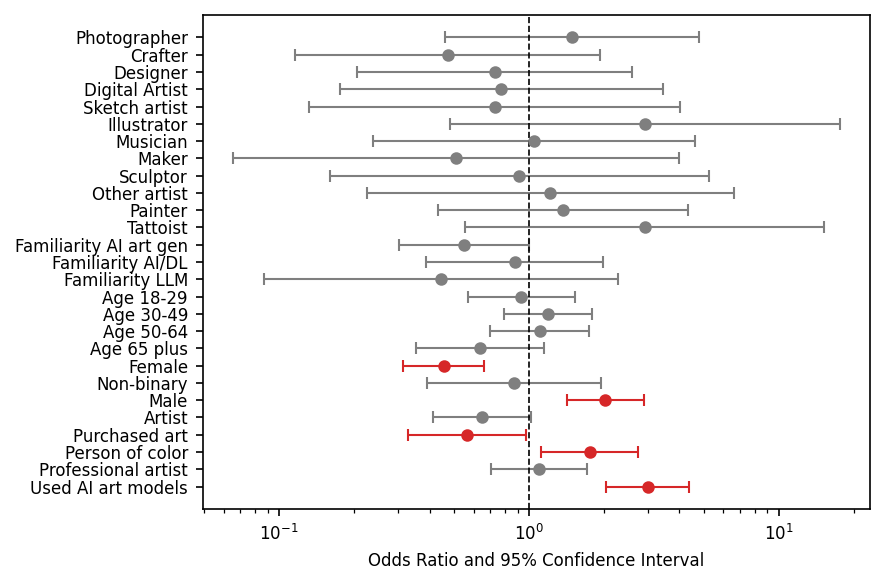

In [260]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)

treeplot(SOAU_B_odds.iloc[:5])
treeplot(SOAU_GM_odds.iloc[:1])
treeplot(SOAU_GNM_odds.iloc[:2])
treeplot(SOAU_AgeO_odds.iloc[:2])
treeplot(SOAU_AgeY_odds.iloc[:2])
treeplot(SOAU_AIfam_odds.iloc[:3])
treeplot(SOAU_Artprac_odds.iloc[:12])


plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
ax.set_xscale('log')

plt.tight_layout()

In [261]:
SOAU_comp_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_user'],
                        Survey[['None, don’t need profit', 'None, donate use of artwork to train models', 'Flat fee',
                                'None, but don’t want for-profit comp to profit', 'None, but don’t want anyone else to profit', 'Not comfortable with any listed',
                                'Portion of any profit from derivatives', 'Portion of any profit from model creators', 'Portion of any profit',
                                'Tax'
                                ]],
                        distr='logit')

SOAU_comp_res_log = SOAU_comp_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOAU_comp_df2plot = pd.DataFrame({
    'or': np.exp(SOAU_comp_res_log.params),
    'var_diag': np.diag(SOAU_comp_res_log.cov_params())
})
SOAU_comp_df2plot['or_se'] = np.sqrt(SOAU_comp_df2plot['or']**2 * SOAU_comp_df2plot['var_diag'])
SOAU_comp_df2plot = SOAU_comp_df2plot.reset_index().rename(columns={'index': 'catego'})

SOAU_comp_res_log.summary()

SOAU_comp_params = SOAU_comp_res_log.params
SOAU_comp_conf = SOAU_comp_res_log.conf_int()
SOAU_comp_conf['Odds Ratio'] = SOAU_comp_params
SOAU_comp_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAU_comp_odds = pd.DataFrame(np.exp(SOAU_comp_conf))
# check if pvalues are significant
SOAU_comp_odds['pvalues'] = SOAU_comp_res_log.pvalues
SOAU_comp_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAU_comp_res_log.pvalues]

SOAU_comp_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
"None, don’t need profit",0.498665,8.015598,1.999275,0.328153,not significant
"None, donate use of artwork to train models",0.965801,11.105517,3.275014,0.056896,not significant
Flat fee,0.259222,3.002946,0.882286,0.841163,not significant
"None, but don’t want for-profit comp to profit",0.159296,1.686612,0.518334,0.274998,not significant
"None, but don’t want anyone else to profit",0.126867,1.973433,0.500362,0.322656,not significant
Not comfortable with any listed,0.057610,0.765249,0.209967,0.018008,significant
Portion of any profit from derivatives,0.164151,2.258827,0.608925,0.458287,not significant
Portion of any profit from model creators,0.108502,1.319073,0.378315,0.127163,not significant
Portion of any profit,0.315746,4.308758,1.166393,0.817425,not significant
Tax,0.132833,5.021371,0.816703,0.827032,not significant


###plotcomp

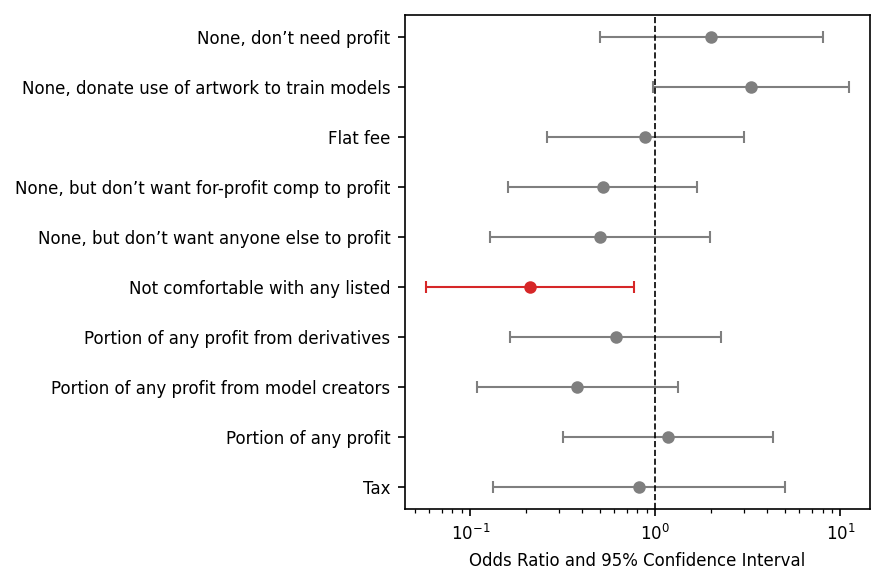

In [262]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)

treeplot(SOAU_comp_odds.iloc[:10])

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
ax.set_xscale('log')
plt.tight_layout()


##Styleof_ownedby_OG_artist

In [263]:
SOOG_B_mod_log = OrderedModel(Survey['Styleof_ownedby_OG_artist'],
                        Survey[['Artist', 'Purchased art', 'Person of color', 'Professional artist', 'Used AI art models',
                                ]],
                        distr='logit')

SOOG_B_res_log = SOOG_B_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOOG_B_df2plot = pd.DataFrame({
    'or': np.exp(SOOG_B_res_log.params),
    'var_diag': np.diag(SOOG_B_res_log.cov_params())
})
SOOG_B_df2plot['or_se'] = np.sqrt(SOOG_B_df2plot['or']**2 * SOOG_B_df2plot['var_diag'])
SOOG_B_df2plot = SOOG_B_df2plot.reset_index().rename(columns={'index': 'catego'})
SOOG_B_res_log.summary()

SOOG_B_params = SOOG_B_res_log.params
SOOG_B_conf = SOOG_B_res_log.conf_int()
SOOG_B_conf['Odds Ratio'] = SOOG_B_params
SOOG_B_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOOG_B_odds = pd.DataFrame(np.exp(SOOG_B_conf))
# check if pvalues are significant
SOOG_B_odds['pvalues'] = SOOG_B_res_log.pvalues
SOOG_B_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOOG_B_res_log.pvalues]
SOOG_B_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Artist,0.601364,1.425504,0.925876,0.726499,not significant
Purchased art,0.682946,1.985811,1.164561,0.575830,not significant
Person of color,1.382372,3.336151,2.147511,0.000672,significant
Professional artist,0.857238,2.014212,1.314024,0.210158,not significant
Used AI art models,0.453536,0.949834,0.656341,0.025556,significant
1.0/2.0,0.367245,1.040491,0.618154,0.070209,not significant
2.0/3.0,0.859630,1.209262,1.019568,0.823851,not significant


In [264]:
SOOG_GM_mod_log = OrderedModel(Survey['Styleof_ownedby_OG_artist'],
                        Survey[['Male']],
                        distr='logit')

SOOG_GM_res_log = SOOG_GM_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOOG_GM_df2plot = pd.DataFrame({
    'or': np.exp(SOOG_GM_res_log.params),
    'var_diag': np.diag(SOOG_GM_res_log.cov_params())
})
SOOG_GM_df2plot['or_se'] = np.sqrt(SOOG_GM_df2plot['or']**2 * SOOG_GM_df2plot['var_diag'])
SOOG_GM_df2plot = SOOG_GM_df2plot.reset_index().rename(columns={'index': 'catego'})
SOOG_GM_res_log.summary()

SOOG_GM_params = SOOG_GM_res_log.params
SOOG_GM_conf = SOOG_GM_res_log.conf_int()
SOOG_GM_conf['Odds Ratio'] = SOOG_GM_params
SOOG_GM_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOOG_GM_odds = pd.DataFrame(np.exp(SOOG_GM_conf))
# check if pvalues are significant
SOOG_GM_odds['pvalues'] = SOOG_GM_res_log.pvalues
SOOG_GM_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOOG_GM_res_log.pvalues]
SOOG_GM_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Male,0.929958,1.863216,1.316326,0.121057,not significant
1.0/2.0,0.476964,0.832460,0.630122,0.001152,significant
2.0/3.0,0.836897,1.176566,0.992303,0.929150,not significant


In [265]:
SOOG_GNM_mod_log = OrderedModel(Survey['Styleof_ownedby_OG_artist'],
                        Survey[['Female','Non-binary']],
                        distr='logit')

SOOG_GNM_res_log = SOOG_GNM_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOOG_GNM_df2plot = pd.DataFrame({
    'or': np.exp(SOOG_GNM_res_log.params),
    'var_diag': np.diag(SOOG_GNM_res_log.cov_params())
})
SOOG_GNM_df2plot['or_se'] = np.sqrt(SOOG_GNM_df2plot['or']**2 * SOOG_GNM_df2plot['var_diag'])
SOOG_GNM_df2plot = SOOG_GNM_df2plot.reset_index().rename(columns={'index': 'catego'})
SOOG_GNM_res_log.summary()

SOOG_GNM_params = SOOG_GNM_res_log.params
SOOG_GNM_conf = SOOG_GNM_res_log.conf_int()
SOOG_GNM_conf['Odds Ratio'] = SOOG_GNM_params
SOOG_GNM_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOOG_GNM_odds = pd.DataFrame(np.exp(SOOG_GNM_conf))
# check if pvalues are significant
SOOG_GNM_odds['pvalues'] = SOOG_GNM_res_log.pvalues
SOOG_GNM_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOOG_GNM_res_log.pvalues]
SOOG_GNM_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Female,0.540109,1.114689,0.775921,1.698881e-01,not significant
Non-binary,0.304406,1.426784,0.659031,2.900150e-01,not significant
1.0/2.0,0.375220,0.610515,0.478621,2.964532e-09,significant
2.0/3.0,0.837121,1.176899,0.992576,9.316727e-01,not significant


In [266]:
SOOG_AgeO_mod_log = OrderedModel(Survey['Styleof_ownedby_OG_artist'],
                        Survey[['Age 50-64','Age 65 plus']],
                        distr='logit')

SOOG_AgeO_res_log = SOOG_AgeO_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOOG_AgeO_df2plot = pd.DataFrame({
    'or': np.exp(SOOG_AgeO_res_log.params),
    'var_diag': np.diag(SOOG_AgeO_res_log.cov_params())
})
SOOG_AgeO_df2plot['or_se'] = np.sqrt(SOOG_AgeO_df2plot['or']**2 * SOOG_AgeO_df2plot['var_diag'])
SOOG_AgeO_df2plot = SOOG_AgeO_df2plot.reset_index().rename(columns={'index': 'catego'})
SOOG_AgeO_res_log.summary()

SOOG_AgeO_params = SOOG_AgeO_res_log.params
SOOG_AgeO_conf = SOOG_AgeO_res_log.conf_int()
SOOG_AgeO_conf['Odds Ratio'] = SOOG_AgeO_params
SOOG_AgeO_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOOG_AgeO_odds = pd.DataFrame(np.exp(SOOG_AgeO_conf))
# check if pvalues are significant
SOOG_AgeO_odds['pvalues'] = SOOG_AgeO_res_log.pvalues
SOOG_AgeO_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOOG_AgeO_res_log.pvalues]
SOOG_AgeO_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Age 50-64,0.433393,1.072792,0.681865,9.770518e-02,not significant
Age 65 plus,0.715666,2.230618,1.263478,4.200041e-01,not significant
1.0/2.0,0.410108,0.640134,0.512371,3.929546e-09,significant
2.0/3.0,0.839241,1.179950,0.995119,9.551089e-01,not significant


In [267]:
SOOG_AgeY_mod_log = OrderedModel(Survey['Styleof_ownedby_OG_artist'],
                        Survey[['Age 18-29','Age 30-49']],
                        distr='logit')

SOOG_AgeY_res_log = SOOG_AgeY_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOOG_AgeY_df2plot = pd.DataFrame({
    'or': np.exp(SOOG_AgeY_res_log.params),
    'var_diag': np.diag(SOOG_AgeY_res_log.cov_params())
})
SOOG_AgeY_df2plot['or_se'] = np.sqrt(SOOG_AgeY_df2plot['or']**2 * SOOG_AgeY_df2plot['var_diag'])
SOOG_AgeY_df2plot = SOOG_AgeY_df2plot.reset_index().rename(columns={'index': 'catego'})
SOOG_AgeY_res_log.summary()

SOOG_AgeY_params = SOOG_AgeY_res_log.params
SOOG_AgeY_conf = SOOG_AgeY_res_log.conf_int()
SOOG_AgeY_conf['Odds Ratio'] = SOOG_AgeY_params
SOOG_AgeY_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOOG_AgeY_odds = pd.DataFrame(np.exp(SOOG_AgeY_conf))
# check if pvalues are significant
SOOG_AgeY_odds['pvalues'] = SOOG_AgeY_res_log.pvalues
SOOG_AgeY_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOOG_AgeY_res_log.pvalues]
SOOG_AgeY_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Age 18-29,0.749478,1.976648,1.217150,0.427012,not significant
Age 30-49,0.766020,1.711638,1.145054,0.508996,not significant
1.0/2.0,0.430538,0.835562,0.599784,0.002511,significant
2.0/3.0,0.834312,1.172830,0.989195,0.900490,not significant


In [268]:
SOOG_AIfam_mod_log = OrderedModel(Survey['Styleof_ownedby_OG_artist'],
                        Survey[['Familiarity AI art gen',
                                'Familiarity AI/DL',
                                'Familiarity LLM',
                                'Familiarity text to image']],
                        distr='logit')

SOOG_AIfam_res_log = SOOG_AIfam_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOOG_AIfam_df2plot = pd.DataFrame({
    'or': np.exp(SOOG_AIfam_res_log.params),
    'var_diag': np.diag(SOOG_AIfam_res_log.cov_params())
})
SOOG_AIfam_df2plot['or_se'] = np.sqrt(SOOG_AIfam_df2plot['or']**2 * SOOG_AIfam_df2plot['var_diag'])
SOOG_AIfam_df2plot = SOOG_AIfam_df2plot.reset_index().rename(columns={'index': 'catego'})
SOOG_AIfam_res_log.summary()

SOOG_AIfam_params = SOOG_AIfam_res_log.params
SOOG_AIfam_conf = SOOG_AIfam_res_log.conf_int()
SOOG_AIfam_conf['Odds Ratio'] = SOOG_AIfam_params
SOOG_AIfam_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOOG_AIfam_odds = pd.DataFrame(np.exp(SOOG_AIfam_conf))
# check if pvalues are significant
SOOG_AIfam_odds['pvalues'] = SOOG_AIfam_res_log.pvalues
SOOG_AIfam_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOOG_AIfam_res_log.pvalues]
SOOG_AIfam_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Familiarity AI art gen,0.341862,1.085694,0.609227,0.092752,not significant
Familiarity AI/DL,0.454393,2.193558,0.998367,0.996753,not significant
Familiarity LLM,0.239351,9.063794,1.472899,0.676175,not significant
Familiarity text to image,0.199754,2.904406,0.761687,0.690169,not significant
1.0/2.0,0.208462,0.632526,0.363122,0.000347,significant
2.0/3.0,0.841979,1.183844,0.998385,0.985162,not significant


In [269]:
SOOG_Artprac_mod_log = OrderedModel(Survey['Styleof_ownedby_OG_artist'],
                        Survey[['Photographer', 'Crafter', 'Designer',
                                'Digital Artist', 'Sketch artist', 'Illustrator',
                                'Musician',
                                'Maker',
                                'Sculptor',
                                'Other artist', 'Painter',
                                'Tattoist', 'Writer']],
                        distr='logit')

SOOG_Artprac_res_log = SOOG_Artprac_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOOG_Artprac_df2plot = pd.DataFrame({
    'or': np.exp(SOOG_Artprac_res_log.params),
    'var_diag': np.diag(SOOG_Artprac_res_log.cov_params())
})
SOOG_Artprac_df2plot['or_se'] = np.sqrt(SOOG_Artprac_df2plot['or']**2 * SOOG_Artprac_df2plot['var_diag'])
SOOG_Artprac_df2plot = SOOG_Artprac_df2plot.reset_index().rename(columns={'index': 'catego'})
SOOG_Artprac_df2plot
SOOG_Artprac_res_log.summary()

SOOG_Artprac_params = SOOG_Artprac_res_log.params
SOOG_Artprac_conf = SOOG_Artprac_res_log.conf_int()
SOOG_Artprac_conf['Odds Ratio'] = SOOG_Artprac_params
SOOG_Artprac_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOOG_Artprac_odds = pd.DataFrame(np.exp(SOOG_Artprac_conf))
# check if pvalues are significant
SOOG_Artprac_odds['pvalues'] = SOOG_Artprac_res_log.pvalues
SOOG_Artprac_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOOG_Artprac_res_log.pvalues]
SOOG_Artprac_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Photographer,0.767339,8.542394,2.560257,0.126216,not significant
Crafter,0.330235,5.508344,1.348721,0.676900,not significant
Designer,0.350222,4.596068,1.268718,0.717050,not significant
Digital Artist,0.350639,7.202454,1.589170,0.547998,not significant
Sketch artist,0.442624,12.710739,2.371937,0.313265,not significant
Illustrator,0.705023,21.346164,3.879373,0.119181,not significant
Musician,0.846183,16.829236,3.773675,0.081682,not significant
Maker,0.093845,6.014805,0.751304,0.787605,not significant
Sculptor,0.563212,23.470174,3.635751,0.174907,not significant
Other artist,0.423624,14.806303,2.504456,0.311247,not significant


###plot

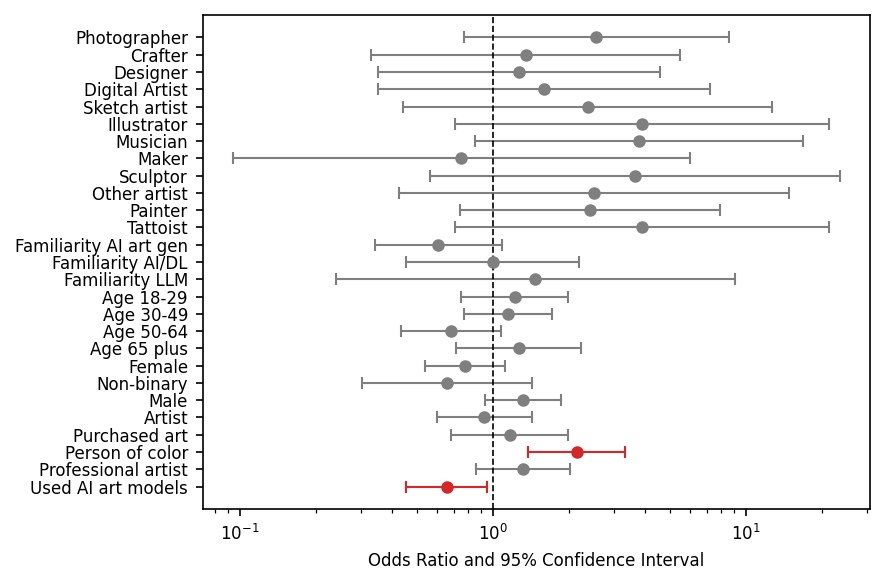

In [270]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)

treeplot(SOOG_B_odds.iloc[:5])
treeplot(SOOG_GM_odds.iloc[:1])
treeplot(SOOG_GNM_odds.iloc[:2])
treeplot(SOOG_AgeO_odds.iloc[:2])
treeplot(SOOG_AgeY_odds.iloc[:2])
treeplot(SOOG_AIfam_odds.iloc[:3])
treeplot(SOOG_Artprac_odds.iloc[:12])

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
ax.set_xscale('log')
plt.tight_layout()

In [271]:
SOOG_comp_mod_log = OrderedModel(Survey['Styleof_ownedby_OG_artist'],
                        Survey[['None, don’t need profit', 'None, donate use of artwork to train models', 'Flat fee',
                                'None, but don’t want for-profit comp to profit', 'None, but don’t want anyone else to profit', 'Not comfortable with any listed',
                                'Portion of any profit from derivatives', 'Portion of any profit from model creators', 'Portion of any profit',
                                'Tax'
                                ]],
                        distr='logit')

SOOG_comp_res_log = SOOG_comp_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOOG_comp_df2plot = pd.DataFrame({
    'or': np.exp(SOOG_comp_res_log.params),
    'var_diag': np.diag(SOOG_comp_res_log.cov_params())
})
SOOG_comp_df2plot['or_se'] = np.sqrt(SOOG_comp_df2plot['or']**2 * SOOG_comp_df2plot['var_diag'])
SOOG_comp_df2plot = SOOG_comp_df2plot.reset_index().rename(columns={'index': 'catego'})
SOOG_comp_res_log.summary()

SOOG_comp_params = SOOG_comp_res_log.params
SOOG_comp_conf = SOOG_comp_res_log.conf_int()
SOOG_comp_conf['Odds Ratio'] = SOOG_comp_params
SOOG_comp_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOOG_comp_odds = pd.DataFrame(np.exp(SOOG_comp_conf))
# check if pvalues are significant
SOOG_comp_odds['pvalues'] = SOOG_comp_res_log.pvalues
SOOG_comp_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOOG_comp_res_log.pvalues]
SOOG_comp_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
"None, don’t need profit",0.252320,3.961372,0.999766,0.999734,not significant
"None, donate use of artwork to train models",0.513752,5.733981,1.716346,0.380072,not significant
Flat fee,0.358686,4.194022,1.226515,0.744814,not significant
"None, but don’t want for-profit comp to profit",0.334713,3.531268,1.087180,0.889399,not significant
"None, but don’t want anyone else to profit",0.418543,6.478014,1.646611,0.475448,not significant
Not comfortable with any listed,0.349148,4.307525,1.226361,0.750228,not significant
Portion of any profit from derivatives,0.409981,5.413260,1.489744,0.544844,not significant
Portion of any profit from model creators,0.573956,6.711130,1.962624,0.282421,not significant
Portion of any profit,0.435868,5.718306,1.578742,0.486822,not significant
Tax,0.532577,29.762374,3.981302,0.178264,not significant


###plotcomp

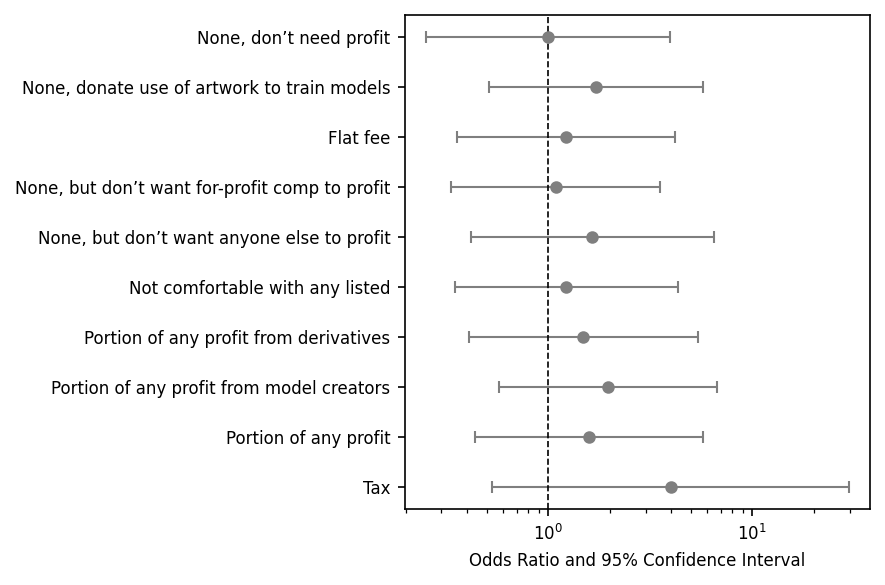

In [272]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)

treeplot(SOOG_comp_odds.iloc[:10])

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
ax.set_xscale('log')
plt.tight_layout()


##Styleof_ownedby_AI_company

In [273]:
SOAIC_B_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_company'],
                        Survey[['Artist', 'Purchased art', 'Person of color', 'Professional artist', 'Used AI art models',
                                ]],
                        distr='logit')

SOAIC_B_res_log = SOAIC_B_mod_log.fit(method='bfgs', disp=False)


# odds-ratio adjusted standard error
SOAIC_B_df2plot = pd.DataFrame({
    'or': np.exp(SOAIC_B_res_log.params),
    'var_diag': np.diag(SOAIC_B_res_log.cov_params())
})
SOAIC_B_df2plot['or_se'] = np.sqrt(SOAIC_B_df2plot['or']**2 * SOAIC_B_df2plot['var_diag'])
SOAIC_B_df2plot = SOAIC_B_df2plot.reset_index().rename(columns={'index': 'catego'})
SOAIC_B_res_log.summary()

SOAIC_B_params = SOAIC_B_res_log.params
SOAIC_B_conf = SOAIC_B_res_log.conf_int()
SOAIC_B_conf['Odds Ratio'] = SOAIC_B_params
SOAIC_B_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAIC_B_odds = pd.DataFrame(np.exp(SOAIC_B_conf))
# check if pvalues are significant
SOAIC_B_odds['pvalues'] = SOAIC_B_res_log.pvalues
SOAIC_B_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAIC_B_res_log.pvalues]
SOAIC_B_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Artist,0.468541,1.160369,0.737347,0.187823,not significant
Purchased art,0.439453,1.302365,0.756523,0.314052,not significant
Person of color,1.603519,3.870710,2.491336,0.000049,significant
Professional artist,0.539563,1.334183,0.848455,0.476731,not significant
Used AI art models,0.684392,1.486553,1.008655,0.965265,not significant
1.0/2.0,0.547344,1.554691,0.922470,0.761875,not significant
2.0/3.0,0.662209,0.999006,0.813358,0.048902,significant


In [274]:
SOAIC_GM_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_company'],
                        Survey[['Male']],
                        distr='logit')

SOAIC_GM_res_log = SOAIC_GM_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOAIC_GM_df2plot = pd.DataFrame({
    'or': np.exp(SOAIC_GM_res_log.params),
    'var_diag': np.diag(SOAIC_GM_res_log.cov_params())
})
SOAIC_GM_df2plot['or_se'] = np.sqrt(SOAIC_GM_df2plot['or']**2 * SOAIC_GM_df2plot['var_diag'])
SOAIC_GM_df2plot = SOAIC_GM_df2plot.reset_index().rename(columns={'index': 'catego'})
SOAIC_GM_res_log.summary()

SOAIC_GM_params = SOAIC_GM_res_log.params
SOAIC_GM_conf = SOAIC_GM_res_log.conf_int()
SOAIC_GM_conf['Odds Ratio'] = SOAIC_GM_params
SOAIC_GM_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAIC_GM_odds = pd.DataFrame(np.exp(SOAIC_GM_conf))
# check if pvalues are significant
SOAIC_GM_odds['pvalues'] = SOAIC_GM_res_log.pvalues
SOAIC_GM_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAIC_GM_res_log.pvalues]
SOAIC_GM_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Male,1.394213,2.965517,2.033362,0.000228,significant
1.0/2.0,1.436762,2.641279,1.948048,0.000018,significant
2.0/3.0,0.647734,0.976651,0.795368,0.028853,significant


In [275]:
SOAIC_GNM_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_company'],
                        Survey[['Female','Non-binary']],
                        distr='logit')


SOAIC_GNM_res_log = SOAIC_GNM_mod_log.fit(method='bfgs', disp=False)


# odds-ratio adjusted standard error
SOAIC_GNM_df2plot = pd.DataFrame({
    'or': np.exp(SOAIC_GNM_res_log.params),
    'var_diag': np.diag(SOAIC_GNM_res_log.cov_params())
})
SOAIC_GNM_df2plot['or_se'] = np.sqrt(SOAIC_GNM_df2plot['or']**2 * SOAIC_GNM_df2plot['var_diag'])
SOAIC_GNM_df2plot = SOAIC_GNM_df2plot.reset_index().rename(columns={'index': 'catego'})
SOAIC_GNM_res_log.summary()

SOAIC_GNM_params = SOAIC_GNM_res_log.params
SOAIC_GNM_conf = SOAIC_GNM_res_log.conf_int()
SOAIC_GNM_conf['Odds Ratio'] = SOAIC_GNM_params
SOAIC_GNM_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAIC_GNM_odds = pd.DataFrame(np.exp(SOAIC_GNM_conf))
# check if pvalues are significant
SOAIC_GNM_odds['pvalues'] = SOAIC_GNM_res_log.pvalues
SOAIC_GNM_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAIC_GNM_res_log.pvalues]
SOAIC_GNM_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Female,0.346730,0.759067,0.513022,0.000841,significant
Non-binary,0.136972,0.921049,0.355187,0.033244,significant
1.0/2.0,0.758537,1.209409,0.957800,0.717128,not significant
2.0/3.0,0.648270,0.977416,0.796008,0.029403,significant


In [276]:
SOAIC_AgeO_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_company'],
                        Survey[['Age 50-64','Age 65 plus']],
                        distr='logit')

SOAIC_AgeO_res_log = SOAIC_AgeO_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
SOAIC_AgeO_df2plot = pd.DataFrame({
    'or': np.exp(SOAIC_AgeO_res_log.params),
    'var_diag': np.diag(SOAIC_AgeO_res_log.cov_params())
})
SOAIC_AgeO_df2plot['or_se'] = np.sqrt(SOAIC_AgeO_df2plot['or']**2 * SOAIC_AgeO_df2plot['var_diag'])
SOAIC_AgeO_df2plot = SOAIC_AgeO_df2plot.reset_index().rename(columns={'index': 'catego'})
SOAIC_AgeO_res_log.summary()

SOAIC_AgeO_params = SOAIC_AgeO_res_log.params
SOAIC_AgeO_conf = SOAIC_AgeO_res_log.conf_int()
SOAIC_AgeO_conf['Odds Ratio'] = SOAIC_AgeO_params
SOAIC_AgeO_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAIC_AgeO_odds = pd.DataFrame(np.exp(SOAIC_AgeO_conf))
# check if pvalues are significant
SOAIC_AgeO_odds['pvalues'] = SOAIC_AgeO_res_log.pvalues
SOAIC_AgeO_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAIC_AgeO_res_log.pvalues]
SOAIC_AgeO_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Age 50-64,0.547054,1.443719,0.888703,0.633636,not significant
Age 65 plus,0.621558,2.010455,1.117861,0.709854,not significant
1.0/2.0,1.007428,1.549686,1.249479,0.042629,significant
2.0/3.0,0.631784,0.952696,0.775821,0.015417,significant


In [277]:
SOAIC_AgeY_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_company'],
                        Survey[['Age 18-29','Age 30-49']],
                        distr='logit')

SOAIC_AgeY_res_log = SOAIC_AgeY_mod_log.fit(method='bfgs', disp=False)
SOAIC_AgeY_res_log.summary()

# odds-ratio adjusted standard error
SOAIC_AgeY_df2plot = pd.DataFrame({
    'or': np.exp(SOAIC_AgeY_res_log.params),
    'var_diag': np.diag(SOAIC_AgeY_res_log.cov_params())
})
SOAIC_AgeY_df2plot['or_se'] = np.sqrt(SOAIC_AgeY_df2plot['or']**2 * SOAIC_AgeY_df2plot['var_diag'])
SOAIC_AgeY_df2plot = SOAIC_AgeY_df2plot.reset_index().rename(columns={'index': 'catego'})

SOAIC_AgeY_params = SOAIC_AgeY_res_log.params
SOAIC_AgeY_conf = SOAIC_AgeY_res_log.conf_int()
SOAIC_AgeY_conf['Odds Ratio'] = SOAIC_AgeY_params
SOAIC_AgeY_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAIC_AgeY_odds = pd.DataFrame(np.exp(SOAIC_AgeY_conf))
# check if pvalues are significant
SOAIC_AgeY_odds['pvalues'] = SOAIC_AgeY_res_log.pvalues
SOAIC_AgeY_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAIC_AgeY_res_log.pvalues]
SOAIC_AgeY_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Age 18-29,0.488074,1.356759,0.813756,0.429419,not significant
Age 30-49,0.750917,1.753871,1.147611,0.524626,not significant
1.0/2.0,0.910481,1.817726,1.286470,0.153223,not significant
2.0/3.0,0.633933,0.955914,0.778451,0.016836,significant


In [278]:
SOAIC_AIfam_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_company'],
                                Survey[['Familiarity AI art gen',
                                'Familiarity AI/DL',
                                'Familiarity LLM',
                                'Familiarity text to image']],
                        distr='logit')

SOAIC_AIfam_res_log = SOAIC_AIfam_mod_log.fit(method='bfgs', disp=False)
SOAIC_AIfam_res_log.summary()

# odds-ratio adjusted standard error
SOAIC_AIfam_df2plot = pd.DataFrame({
    'or': np.exp(SOAIC_AIfam_res_log.params),
    'var_diag': np.diag(SOAIC_AIfam_res_log.cov_params())
})
SOAIC_AIfam_df2plot['or_se'] = np.sqrt(SOAIC_AIfam_df2plot['or']**2 * SOAIC_AIfam_df2plot['var_diag'])
SOAIC_AIfam_df2plot = SOAIC_AIfam_df2plot.reset_index().rename(columns={'index': 'catego'})

SOAIC_AIfam_params = SOAIC_AIfam_res_log.params
SOAIC_AIfam_conf = SOAIC_AIfam_res_log.conf_int()
SOAIC_AIfam_conf['Odds Ratio'] = SOAIC_AIfam_params
SOAIC_AIfam_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAIC_AIfam_odds = pd.DataFrame(np.exp(SOAIC_AIfam_conf))
# check if pvalues are significant
SOAIC_AIfam_odds['pvalues'] = SOAIC_AIfam_res_log.pvalues
SOAIC_AIfam_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAIC_AIfam_res_log.pvalues]
SOAIC_AIfam_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Familiarity AI art gen,0.152611,0.486134,0.272377,0.000011,significant
Familiarity AI/DL,0.375901,1.823414,0.827903,0.639206,not significant
Familiarity LLM,0.120181,3.748762,0.671215,0.649641,not significant
Familiarity text to image,0.140257,1.564695,0.468465,0.217808,not significant
1.0/2.0,0.257704,0.768379,0.444988,0.003669,significant
2.0/3.0,0.669783,1.011007,0.822895,0.063490,not significant


In [279]:
SOAIC_Artprac_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_company'],
                        Survey[['Photographer', 'Crafter', 'Designer',
                                'Digital Artist', 'Sketch artist', 'Illustrator',
                                'Musician',
                                'Maker',
                                'Sculptor',
                                'Other artist', 'Painter',
                                'Tattoist', 'Writer']],
                        distr='logit')

SOAIC_Artprac_res_log = SOAIC_Artprac_mod_log.fit(method='bfgs', disp=False)
SOAIC_Artprac_res_log.summary()

# odds-ratio adjusted standard error
SOAIC_Artprac_df2plot = pd.DataFrame({
    'or': np.exp(SOAIC_Artprac_res_log.params),
    'var_diag': np.diag(SOAIC_Artprac_res_log.cov_params())
})
SOAIC_Artprac_df2plot['or_se'] = np.sqrt(SOAIC_Artprac_df2plot['or']**2 * SOAIC_Artprac_df2plot['var_diag'])
SOAIC_Artprac_df2plot = SOAIC_Artprac_df2plot.reset_index().rename(columns={'index': 'catego'})

SOAIC_Artprac_params = SOAIC_Artprac_res_log.params
SOAIC_Artprac_conf = SOAIC_Artprac_res_log.conf_int()
SOAIC_Artprac_conf['Odds Ratio'] = SOAIC_Artprac_params
SOAIC_Artprac_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAIC_Artprac_odds = pd.DataFrame(np.exp(SOAIC_Artprac_conf))
# check if pvalues are significant
SOAIC_Artprac_odds['pvalues'] = SOAIC_Artprac_res_log.pvalues
SOAIC_Artprac_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAIC_Artprac_res_log.pvalues]
SOAIC_Artprac_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Photographer,0.487757,6.184520,1.736820,0.394225,not significant
Crafter,0.174597,3.568943,0.789385,0.758671,not significant
Designer,0.207425,3.227255,0.818176,0.774409,not significant
Digital Artist,0.037919,1.787102,0.260319,0.170916,not significant
Sketch artist,0.289616,10.860348,1.773507,0.535461,not significant
Illustrator,0.239963,8.326074,1.413490,0.702103,not significant
Musician,0.256817,5.623486,1.201752,0.815437,not significant
Maker,0.035642,5.508235,0.443085,0.526711,not significant
Sculptor,0.121091,8.227352,0.998126,0.998609,not significant
Other artist,0.239959,8.326229,1.413490,0.702106,not significant


###plot

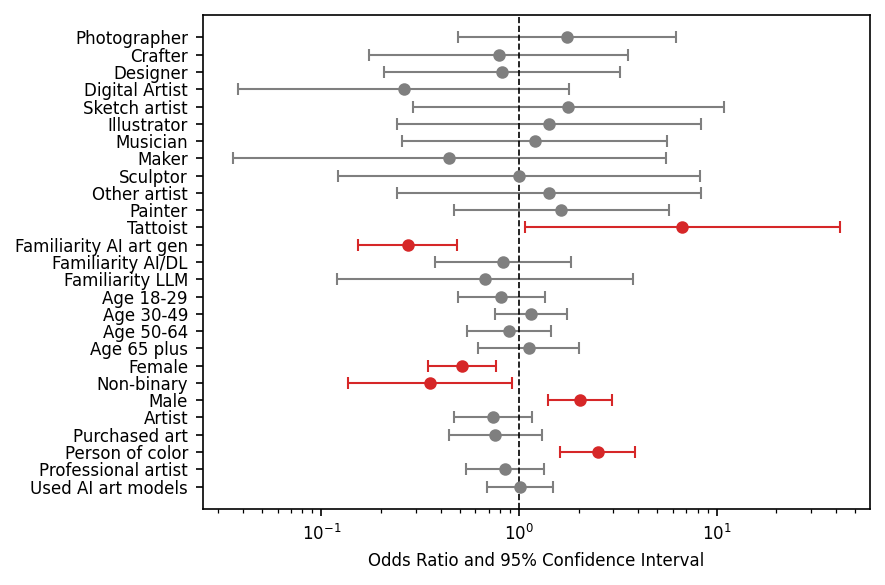

In [280]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)

treeplot(SOAIC_B_odds.iloc[:5])
treeplot(SOAIC_GM_odds.iloc[:1])
treeplot(SOAIC_GNM_odds.iloc[:2])
treeplot(SOAIC_AgeO_odds.iloc[:2])
treeplot(SOAIC_AgeY_odds.iloc[:2])
treeplot(SOAIC_AIfam_odds.iloc[:3])
treeplot(SOAIC_Artprac_odds.iloc[:12])

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
ax.set_xscale('log')
plt.tight_layout()


In [281]:
SOAIC_comp_mod_log = OrderedModel(Survey['Styleof_ownedby_AI_company'],
                        Survey[['None, don’t need profit', 'None, donate use of artwork to train models', 'Flat fee',
                                'None, but don’t want for-profit comp to profit', 'None, but don’t want anyone else to profit', 'Not comfortable with any listed',
                                'Portion of any profit from derivatives', 'Portion of any profit from model creators', 'Portion of any profit',
                                'Tax'
                                ]],
                        distr='logit')

SOAIC_comp_res_log = SOAIC_comp_mod_log.fit(method='bfgs', disp=False)
SOAIC_comp_res_log.summary()

# odds-ratio adjusted standard error
SOAIC_comp_df2plot = pd.DataFrame({
    'or': np.exp(SOAIC_comp_res_log.params),
    'var_diag': np.diag(SOAIC_comp_res_log.cov_params())
})
SOAIC_comp_df2plot['or_se'] = np.sqrt(SOAIC_comp_df2plot['or']**2 * SOAIC_comp_df2plot['var_diag'])
SOAIC_comp_df2plot = SOAIC_comp_df2plot.reset_index().rename(columns={'index': 'catego'})

SOAIC_comp_params = SOAIC_comp_res_log.params
SOAIC_comp_conf = SOAIC_comp_res_log.conf_int()
SOAIC_comp_conf['Odds Ratio'] = SOAIC_comp_params
SOAIC_comp_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
SOAIC_comp_odds = pd.DataFrame(np.exp(SOAIC_comp_conf))
# check if pvalues are significant
SOAIC_comp_odds['pvalues'] = SOAIC_comp_res_log.pvalues
SOAIC_comp_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in SOAIC_comp_res_log.pvalues]
SOAIC_comp_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
"None, don’t need profit",0.760080,16.216441,3.510811,0.107708,not significant
"None, donate use of artwork to train models",1.512847,24.393075,6.074783,0.010970,significant
Flat fee,0.871625,14.630981,3.571096,0.076892,not significant
"None, but don’t want for-profit comp to profit",0.303420,4.788926,1.205429,0.790657,not significant
"None, but don’t want anyone else to profit",0.177118,4.423683,0.885163,0.881873,not significant
Not comfortable with any listed,0.215123,4.097410,0.938854,0.933113,not significant
Portion of any profit from derivatives,0.285511,5.930689,1.301260,0.733653,not significant
Portion of any profit from model creators,0.292329,5.254805,1.239407,0.770881,not significant
Portion of any profit,0.621704,11.541633,2.678708,0.186106,not significant
Tax,0.355144,20.211859,2.679203,0.339136,not significant


###plotcomp

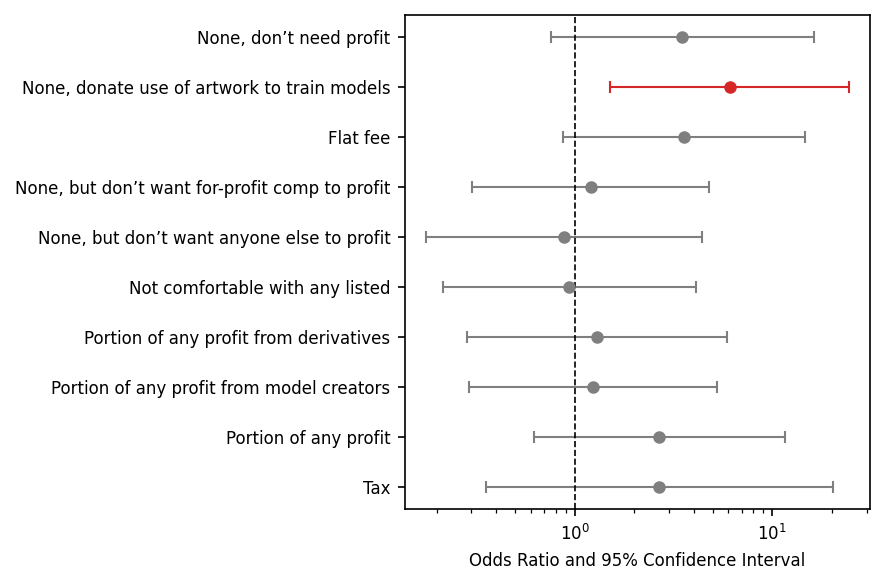

In [282]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)

treeplot(SOAIC_comp_odds.iloc[:10])

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
ax.set_xscale('log')

plt.tight_layout()

##Required_disclosure

In [283]:
Survey['Required_disclosure'].value_counts()

Required_disclosure
3.0    363
2.0     53
1.0     36
Name: count, dtype: int64

In [284]:
RD_B_mod_log = OrderedModel(Survey['Required_disclosure'],
                        Survey[['Artist', 'Purchased art', 'Person of color', 'Professional artist', 'Used AI art models',
                                ]],
                        distr='logit')

RD_B_res_log = RD_B_mod_log.fit(method='bfgs', disp=False)


# odds-ratio adjusted standard error
RD_B_df2plot = pd.DataFrame({
    'or': np.exp(RD_B_res_log.params),
    'var_diag': np.diag(RD_B_res_log.cov_params())
})
RD_B_df2plot['or_se'] = np.sqrt(RD_B_df2plot['or']**2 * RD_B_df2plot['var_diag'])
RD_B_df2plot = RD_B_df2plot.reset_index().rename(columns={'index': 'catego'})
RD_B_res_log.summary()

RD_B_params = RD_B_res_log.params
RD_B_conf = RD_B_res_log.conf_int()
RD_B_conf['Odds Ratio'] = RD_B_params
RD_B_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
RD_B_odds = pd.DataFrame(np.exp(RD_B_conf))
# check if pvalues are significant
RD_B_odds['pvalues'] = RD_B_res_log.pvalues
RD_B_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in RD_B_res_log.pvalues]
RD_B_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Artist,0.618355,1.949844,1.098041,7.495484e-01,not significant
Purchased art,0.851732,3.164821,1.641822,1.386891e-01,not significant
Person of color,0.809301,2.740342,1.489215,2.005643e-01,not significant
Professional artist,0.640443,2.007340,1.133837,6.664713e-01,not significant
Used AI art models,0.386450,1.045068,0.635505,7.405577e-02,not significant
1.0/2.0,0.064004,0.246088,0.125501,1.532481e-09,significant
2.0/3.0,0.807743,1.369193,1.051645,7.083800e-01,not significant


In [285]:
RD_GM_mod_log = OrderedModel(Survey['Required_disclosure'],
                        Survey[['Male']],
                        distr='logit')

RD_GM_res_log = RD_GM_mod_log.fit(method='bfgs', disp=False)
RD_GM_res_log.summary()

# odds-ratio adjusted standard error
RD_GM_df2plot = pd.DataFrame({
    'or': np.exp(RD_GM_res_log.params),
    'var_diag': np.diag(RD_GM_res_log.cov_params())
})
RD_GM_df2plot['or_se'] = np.sqrt(RD_GM_df2plot['or']**2 * RD_GM_df2plot['var_diag'])
RD_GM_df2plot = RD_GM_df2plot.reset_index().rename(columns={'index': 'catego'})

RD_GM_params = RD_GM_res_log.params
RD_GM_conf = RD_GM_res_log.conf_int()
RD_GM_conf['Odds Ratio'] = RD_GM_params
RD_GM_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
RD_GM_odds = pd.DataFrame(np.exp(RD_GM_conf))
# check if pvalues are significant
RD_GM_odds['pvalues'] = RD_GM_res_log.pvalues
RD_GM_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in RD_GM_res_log.pvalues]
RD_GM_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Male,0.587018,1.506886,0.940515,7.987246e-01,not significant
1.0/2.0,0.053471,0.130066,0.083395,6.299935e-28,significant
2.0/3.0,0.799497,1.356998,1.041592,7.626988e-01,not significant


In [286]:
RD_GNM_mod_log = OrderedModel(Survey['Required_disclosure'],
                        Survey[['Female','Non-binary']],
                        distr='logit')

RD_GNM_res_log = RD_GNM_mod_log.fit(method='bfgs', disp=False)
RD_GNM_res_log.summary()

# odds-ratio adjusted standard error
RD_GNM_df2plot = pd.DataFrame({
    'or': np.exp(RD_GNM_res_log.params),
    'var_diag': np.diag(RD_GNM_res_log.cov_params())
})
RD_GNM_df2plot['or_se'] = np.sqrt(RD_GNM_df2plot['or']**2 * RD_GNM_df2plot['var_diag'])
RD_GNM_df2plot = RD_GNM_df2plot.reset_index().rename(columns={'index': 'catego'})

RD_GNM_params = RD_GNM_res_log.params
RD_GNM_conf = RD_GNM_res_log.conf_int()
RD_GNM_conf['Odds Ratio'] = RD_GNM_params
RD_GNM_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
RD_GNM_odds = pd.DataFrame(np.exp(RD_GNM_conf))
# check if pvalues are significant
RD_GNM_odds['pvalues'] = RD_GNM_res_log.pvalues
RD_GNM_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in RD_GNM_res_log.pvalues]
RD_GNM_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Female,0.669859,1.797992,1.097452,7.119889e-01,not significant
Non-binary,0.305430,2.406881,0.857399,7.701784e-01,not significant
1.0/2.0,0.060140,0.130655,0.088643,1.847728e-34,significant
2.0/3.0,0.799740,1.357349,1.041886,7.610880e-01,not significant


In [287]:
RD_AgeO_mod_log = OrderedModel(Survey['Required_disclosure'],
                        Survey[['Age 50-64','Age 65 plus']],
                        distr='logit')

RD_AgeO_res_log = RD_AgeO_mod_log.fit(method='bfgs', disp=False)
RD_AgeO_res_log.summary()

# odds-ratio adjusted standard error
RD_AgeO_df2plot = pd.DataFrame({
    'or': np.exp(RD_AgeO_res_log.params),
    'var_diag': np.diag(RD_AgeO_res_log.cov_params())
})
RD_AgeO_df2plot['or_se'] = np.sqrt(RD_AgeO_df2plot['or']**2 * RD_AgeO_df2plot['var_diag'])
RD_AgeO_df2plot = RD_AgeO_df2plot.reset_index().rename(columns={'index': 'catego'})

RD_AgeO_params = RD_AgeO_res_log.params
RD_AgeO_conf = RD_AgeO_res_log.conf_int()
RD_AgeO_conf['Odds Ratio'] = RD_AgeO_params
RD_AgeO_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
RD_AgeO_odds = pd.DataFrame(np.exp(RD_AgeO_conf))
# check if pvalues are significant
RD_AgeO_odds['pvalues'] = RD_AgeO_res_log.pvalues
RD_AgeO_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in RD_AgeO_res_log.pvalues]
RD_AgeO_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Age 50-64,0.236998,0.712557,0.410944,1.541478e-03,significant
Age 65 plus,0.325902,1.573660,0.716142,4.058610e-01,not significant
1.0/2.0,0.046481,0.100914,0.068488,7.216085e-42,significant
2.0/3.0,0.813978,1.378896,1.059430,6.676852e-01,not significant


In [288]:
RD_AgeY_mod_log = OrderedModel(Survey['Required_disclosure'],
                        Survey[['Age 18-29','Age 30-49']],
                        distr='logit')

RD_AgeY_res_log = RD_AgeY_mod_log.fit(method='bfgs', disp=False)
RD_AgeY_res_log.summary()

# odds-ratio adjusted standard error
RD_AgeY_df2plot = pd.DataFrame({
    'or': np.exp(RD_AgeY_res_log.params),
    'var_diag': np.diag(RD_AgeY_res_log.cov_params())
})
RD_AgeY_df2plot['or_se'] = np.sqrt(RD_AgeY_df2plot['or']**2 * RD_AgeY_df2plot['var_diag'])
RD_AgeY_df2plot = RD_AgeY_df2plot.reset_index().rename(columns={'index': 'catego'})

RD_AgeY_params = RD_AgeY_res_log.params
RD_AgeY_conf = RD_AgeY_res_log.conf_int()
RD_AgeY_conf['Odds Ratio'] = RD_AgeY_params
RD_AgeY_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
RD_AgeY_odds = pd.DataFrame(np.exp(RD_AgeY_conf))
# check if pvalues are significant
RD_AgeY_odds['pvalues'] = RD_AgeY_res_log.pvalues
RD_AgeY_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in RD_AgeY_res_log.pvalues]
RD_AgeY_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Age 18-29,1.427261,5.790101,2.874715,3.118722e-03,significant
Age 30-49,1.061875,2.975780,1.777612,2.864476e-02,significant
1.0/2.0,0.088225,0.220947,0.139617,4.212695e-17,significant
2.0/3.0,0.813150,1.377259,1.058262,6.735638e-01,not significant


In [289]:
RD_AIfam_mod_log = OrderedModel(Survey['Required_disclosure'],
                        Survey[['Familiarity AI art gen',
                                'Familiarity AI/DL',
                                'Familiarity text to image']],
                        distr='logit')

RD_AIfam_res_log = RD_AIfam_mod_log.fit(method='bfgs', disp=False)
RD_AIfam_res_log.summary()

# odds-ratio adjusted standard error
RD_AIfam_df2plot = pd.DataFrame({
    'or': np.exp(RD_AIfam_res_log.params),
    'var_diag': np.diag(RD_AIfam_res_log.cov_params())
})
RD_AIfam_df2plot['or_se'] = np.sqrt(RD_AIfam_df2plot['or']**2 * RD_AIfam_df2plot['var_diag'])
RD_AIfam_df2plot = RD_AIfam_df2plot.reset_index().rename(columns={'index': 'catego'})

RD_AIfam_params = RD_AIfam_res_log.params
RD_AIfam_conf = RD_AIfam_res_log.conf_int()
RD_AIfam_conf['Odds Ratio'] = RD_AIfam_params
RD_AIfam_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
RD_AIfam_odds = pd.DataFrame(np.exp(RD_AIfam_conf))
# check if pvalues are significant
RD_AIfam_odds['pvalues'] = RD_AIfam_res_log.pvalues
RD_AIfam_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in RD_AIfam_res_log.pvalues]
RD_AIfam_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Familiarity AI art gen,1.363085,5.053680,2.624614,3.894586e-03,significant
Familiarity AI/DL,0.879414,6.605245,2.410134,8.723737e-02,not significant
Familiarity text to image,0.131881,1.593150,0.458373,2.197219e-01,not significant
1.0/2.0,0.096143,0.342915,0.181573,1.447338e-07,significant
2.0/3.0,0.825991,1.398775,1.074884,5.910131e-01,not significant


In [290]:
RD_Artprac_mod_log = OrderedModel(Survey['Required_disclosure'],
                        Survey[['Photographer', 'Crafter', 'Designer',
                                'Digital Artist', 'Sketch artist', 'Illustrator',
                                'Musician',
                                'Other artist', 'Painter',
                                'Tattoist', 'Writer']],
                        distr='logit')

RD_Artprac_res_log = RD_Artprac_mod_log.fit(method='bfgs', disp=False)
RD_Artprac_res_log.summary()

# odds-ratio adjusted standard error
RD_Artprac_df2plot = pd.DataFrame({
    'or': np.exp(RD_Artprac_res_log.params),
    'var_diag': np.diag(RD_Artprac_res_log.cov_params())
})
RD_Artprac_df2plot['or_se'] = np.sqrt(RD_Artprac_df2plot['or']**2 * RD_Artprac_df2plot['var_diag'])
RD_Artprac_df2plot = RD_Artprac_df2plot.reset_index().rename(columns={'index': 'catego'})

RD_Artprac_params = RD_Artprac_res_log.params
RD_Artprac_conf = RD_Artprac_res_log.conf_int()
RD_Artprac_conf['Odds Ratio'] = RD_Artprac_params
RD_Artprac_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
RD_Artprac_odds = pd.DataFrame(np.exp(RD_Artprac_conf))
# check if pvalues are significant
RD_Artprac_odds['pvalues'] = RD_Artprac_res_log.pvalues
RD_Artprac_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in RD_Artprac_res_log.pvalues]
RD_Artprac_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Photographer,0.026665,1.656513,0.210170,0.138655,not significant
Crafter,0.020146,1.971367,0.199289,0.167743,not significant
Designer,0.021091,1.532809,0.179801,0.116568,not significant
Digital Artist,0.013077,1.343422,0.132543,0.087241,not significant
Sketch artist,0.018934,6.359606,0.347009,0.475682,not significant
Illustrator,0.006274,0.725497,0.067464,0.026098,significant
Musician,0.022443,2.549968,0.239228,0.236150,not significant
Other artist,0.014510,2.365917,0.185285,0.194532,not significant
Painter,0.036576,2.225627,0.285316,0.231452,not significant
Tattoist,0.022214,7.300981,0.402718,0.538408,not significant


###plot

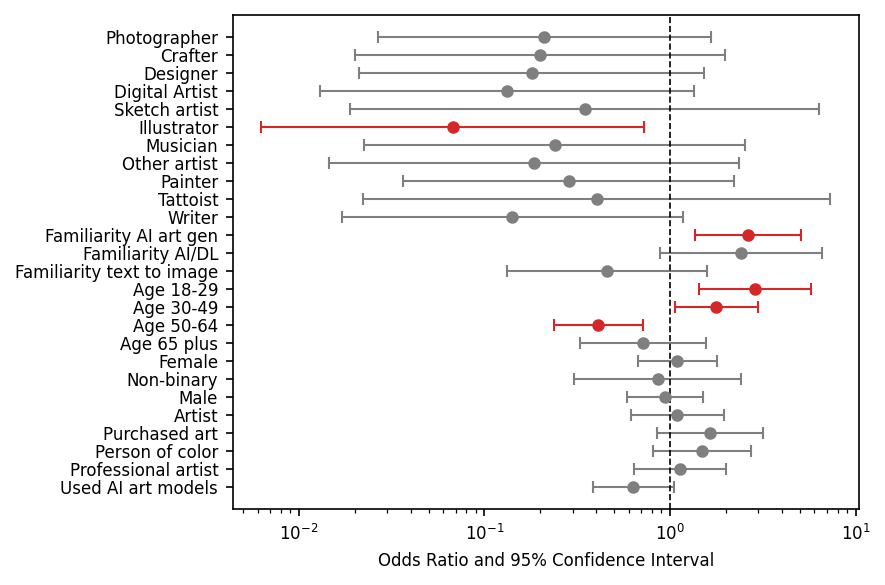

In [291]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)

treeplot(RD_B_odds.iloc[:5])
treeplot(RD_GM_odds.iloc[:1])
treeplot(RD_GNM_odds.iloc[:2])
treeplot(RD_AgeO_odds.iloc[:2])
treeplot(RD_AgeY_odds.iloc[:2])
treeplot(RD_AIfam_odds.iloc[:3])
treeplot(RD_Artprac_odds.iloc[:11])

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
ax.set_xscale('log')
plt.tight_layout()

In [292]:
RD_comp_mod_log = OrderedModel(Survey['Required_disclosure'],
                        Survey[['None, don’t need profit', 'None, donate use of artwork to train models', 'Flat fee',
                                'None, but don’t want for-profit comp to profit', 'None, but don’t want anyone else to profit', 'Not comfortable with any listed',
                                'Portion of any profit from derivatives', 'Portion of any profit from model creators', 'Portion of any profit',
                                ]],
                        distr='logit')

RD_comp_res_log = RD_comp_mod_log.fit(method='bfgs', disp=False)


# odds-ratio adjusted standard error
RD_comp_df2plot = pd.DataFrame({
    'or': np.exp(RD_comp_res_log.params),
    'var_diag': np.diag(RD_comp_res_log.cov_params())
})
RD_comp_df2plot['or_se'] = np.sqrt(RD_comp_df2plot['or']**2 * RD_comp_df2plot['var_diag'])
RD_comp_df2plot = RD_comp_df2plot.reset_index().rename(columns={'index': 'catego'})


RD_comp_params = RD_comp_res_log.params
RD_comp_conf = RD_comp_res_log.conf_int()
RD_comp_conf['Odds Ratio'] = RD_comp_params
RD_comp_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
RD_comp_odds = pd.DataFrame(np.exp(RD_comp_conf))
# check if pvalues are significant
RD_comp_odds['pvalues'] = RD_comp_res_log.pvalues
RD_comp_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in RD_comp_res_log.pvalues]
RD_comp_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
"None, don’t need profit",0.105173,1.407149,0.384701,0.148810,not significant
"None, donate use of artwork to train models",0.446605,4.575144,1.429434,0.547225,not significant
Flat fee,0.670956,8.716645,2.418365,0.177032,not significant
"None, but don’t want for-profit comp to profit",0.639246,6.378818,2.019314,0.231116,not significant
"None, but don’t want anyone else to profit",0.643891,15.548169,3.164068,0.156186,not significant
Not comfortable with any listed,0.559388,7.355529,2.028445,0.281879,not significant
Portion of any profit from derivatives,1.100951,37.925791,6.461768,0.038783,significant
Portion of any profit from model creators,1.051359,16.889636,4.213914,0.042288,significant
Portion of any profit,0.327584,4.283127,1.184518,0.796243,not significant
1.0/2.0,0.051767,0.436390,0.150301,0.000493,significant


###plotcomp

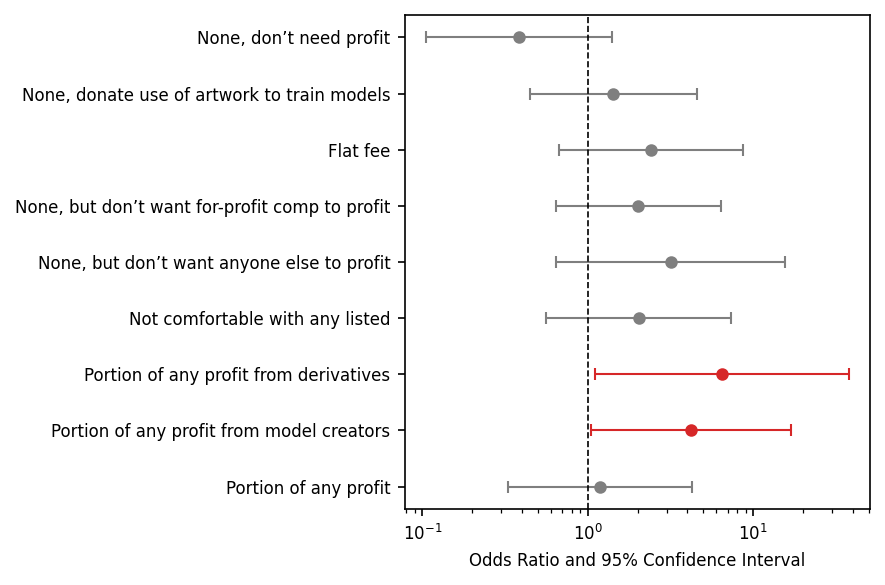

In [293]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)

treeplot(RD_comp_odds.iloc[:9])

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
ax.set_xscale('log')
plt.tight_layout()


##AI_threat_2art_workers

In [294]:
T2W_B_mod_log = OrderedModel(Survey['AI_threat_2art_workers'],
                        Survey[['Artist', 'Purchased art', 'Person of color', 'Professional artist', 'Used AI art models',
                                ]],
                        distr='logit')

T2W_B_res_log = T2W_B_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
T2W_B_df2plot = pd.DataFrame({
    'or': np.exp(T2W_B_res_log.params),
    'var_diag': np.diag(T2W_B_res_log.cov_params())
})
T2W_B_df2plot['or_se'] = np.sqrt(T2W_B_df2plot['or']**2 * T2W_B_df2plot['var_diag'])
T2W_B_df2plot = T2W_B_df2plot.reset_index().rename(columns={'index': 'catego'})
T2W_B_res_log.summary()

T2W_B_params = T2W_B_res_log.params
T2W_B_conf = T2W_B_res_log.conf_int()
T2W_B_conf['Odds Ratio'] = T2W_B_params
T2W_B_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
T2W_B_odds = pd.DataFrame(np.exp(T2W_B_conf))
# check if pvalues are significant
T2W_B_odds['pvalues'] = T2W_B_res_log.pvalues
T2W_B_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in T2W_B_res_log.pvalues]

T2W_B_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Artist,0.673062,1.734431,1.080453,7.486353e-01,not significant
Purchased art,0.565150,1.850283,1.022589,9.411459e-01,not significant
Person of color,0.835831,2.157276,1.342802,2.230016e-01,not significant
Professional artist,0.511389,1.279910,0.809031,3.652110e-01,not significant
Used AI art models,0.381466,0.843053,0.567094,5.049156e-03,significant
1.0/2.0,0.110713,0.359717,0.199563,8.269538e-08,significant
2.0/3.0,0.700588,1.064899,0.863745,1.702828e-01,not significant


In [295]:
T2W_GM_mod_log = OrderedModel(Survey['AI_threat_2art_workers'],
                        Survey[['Male']],
                        distr='logit')

T2W_GM_res_log = T2W_GM_mod_log.fit(method='bfgs', disp=False)
T2W_GM_res_log.summary()

# odds-ratio adjusted standard error
T2W_GM_df2plot = pd.DataFrame({
    'or': np.exp(T2W_GM_res_log.params),
    'var_diag': np.diag(T2W_GM_res_log.cov_params())
})
T2W_GM_df2plot['or_se'] = np.sqrt(T2W_GM_df2plot['or']**2 * T2W_GM_df2plot['var_diag'])
T2W_GM_df2plot = T2W_GM_df2plot.reset_index().rename(columns={'index': 'catego'})

T2W_GM_params = T2W_GM_res_log.params
T2W_GM_conf = T2W_GM_res_log.conf_int()
T2W_GM_conf['Odds Ratio'] = T2W_GM_params
T2W_GM_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
T2W_GM_odds = pd.DataFrame(np.exp(T2W_GM_conf))
# check if pvalues are significant
T2W_GM_odds['pvalues'] = T2W_GM_res_log.pvalues
T2W_GM_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in T2W_GM_res_log.pvalues]

T2W_GM_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Male,0.683150,1.452222,0.996035,9.835232e-01,not significant
1.0/2.0,0.187729,0.355769,0.258434,1.067728e-16,significant
2.0/3.0,0.684942,1.041517,0.844617,1.142234e-01,not significant


In [296]:
T2W_GNM_mod_log = OrderedModel(Survey['AI_threat_2art_workers'],
                        Survey[['Female','Non-binary']],
                        distr='logit')

T2W_GNM_res_log = T2W_GNM_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
T2W_GNM_df2plot = pd.DataFrame({
    'or': np.exp(T2W_GNM_res_log.params),
    'var_diag': np.diag(T2W_GNM_res_log.cov_params())
})
T2W_GNM_df2plot['or_se'] = np.sqrt(T2W_GNM_df2plot['or']**2 * T2W_GNM_df2plot['var_diag'])
T2W_GNM_df2plot = T2W_GNM_df2plot.reset_index().rename(columns={'index': 'catego'})
T2W_GNM_res_log.summary()

T2W_GNM_params = T2W_GNM_res_log.params
T2W_GNM_conf = T2W_GNM_res_log.conf_int()
T2W_GNM_conf['Odds Ratio'] = T2W_GNM_params
T2W_GNM_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
T2W_GNM_odds = pd.DataFrame(np.exp(T2W_GNM_conf))
# check if pvalues are significant
T2W_GNM_odds['pvalues'] = T2W_GNM_res_log.pvalues
T2W_GNM_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in T2W_GNM_res_log.pvalues]
T2W_GNM_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Female,0.678301,1.484131,1.003338,9.866877e-01,not significant
Non-binary,0.416130,2.447633,1.009224,9.837937e-01,not significant
1.0/2.0,0.197153,0.341493,0.259473,6.168129e-22,significant
2.0/3.0,0.684945,1.041517,0.844620,1.142247e-01,not significant


In [297]:
T2W_AgeO_mod_log = OrderedModel(Survey['AI_threat_2art_workers'],
                        Survey[['Age 50-64','Age 65 plus']],
                        distr='logit')

T2W_AgeO_res_log = T2W_AgeO_mod_log.fit(method='bfgs', disp=False)
T2W_AgeO_res_log.summary()

# odds-ratio adjusted standard error
T2W_AgeO_df2plot = pd.DataFrame({
    'or': np.exp(T2W_AgeO_res_log.params),
    'var_diag': np.diag(T2W_AgeO_res_log.cov_params())
})
T2W_AgeO_df2plot['or_se'] = np.sqrt(T2W_AgeO_df2plot['or']**2 * T2W_AgeO_df2plot['var_diag'])
T2W_AgeO_df2plot = T2W_AgeO_df2plot.reset_index().rename(columns={'index': 'catego'})

T2W_AgeO_params = T2W_AgeO_res_log.params
T2W_AgeO_conf = T2W_AgeO_res_log.conf_int()
T2W_AgeO_conf['Odds Ratio'] = T2W_AgeO_params
T2W_AgeO_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
T2W_AgeO_odds = pd.DataFrame(np.exp(T2W_AgeO_conf))
# check if pvalues are significant
T2W_AgeO_odds['pvalues'] = T2W_AgeO_res_log.pvalues
T2W_AgeO_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in T2W_AgeO_res_log.pvalues]
T2W_AgeO_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Age 50-64,0.399295,1.029979,0.641299,6.609575e-02,not significant
Age 65 plus,0.385716,1.286586,0.704455,2.542950e-01,not significant
1.0/2.0,0.175578,0.297028,0.228367,3.382076e-28,significant
2.0/3.0,0.690116,1.049283,0.850957,1.310675e-01,not significant


In [298]:
T2W_AgeY_mod_log = OrderedModel(Survey['AI_threat_2art_workers'],
                        Survey[['Age 18-29','Age 30-49']],
                        distr='logit')

T2W_AgeY_res_log = T2W_AgeY_mod_log.fit(method='bfgs', disp=False)
T2W_AgeY_res_log.summary()

# odds-ratio adjusted standard error
T2W_AgeY_df2plot = pd.DataFrame({
    'or': np.exp(T2W_AgeY_res_log.params),
    'var_diag': np.diag(T2W_AgeY_res_log.cov_params())
})
T2W_AgeY_df2plot['or_se'] = np.sqrt(T2W_AgeY_df2plot['or']**2 * T2W_AgeY_df2plot['var_diag'])
T2W_AgeY_df2plot = T2W_AgeY_df2plot.reset_index().rename(columns={'index': 'catego'})

T2W_AgeY_params = T2W_AgeY_res_log.params
T2W_AgeY_conf = T2W_AgeY_res_log.conf_int()
T2W_AgeY_conf['Odds Ratio'] = T2W_AgeY_params
T2W_AgeY_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
T2W_AgeY_odds = pd.DataFrame(np.exp(T2W_AgeY_conf))
# check if pvalues are significant
T2W_AgeY_odds['pvalues'] = T2W_AgeY_res_log.pvalues
T2W_AgeY_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in T2W_AgeY_res_log.pvalues]
T2W_AgeY_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Age 18-29,1.337791,4.055724,2.329316,2.803364e-03,significant
Age 30-49,0.829556,1.938754,1.268190,2.725991e-01,not significant
1.0/2.0,0.239770,0.489129,0.342459,3.818078e-09,significant
2.0/3.0,0.696435,1.058456,0.858572,1.533060e-01,not significant


In [299]:
T2W_AIfam_mod_log = OrderedModel(Survey['AI_threat_2art_workers'],
                        Survey[['Familiarity AI art gen',
                                'Familiarity AI/DL',
                                'Familiarity LLM',
                                'Familiarity text to image']],
                        distr='logit')

T2W_AIfam_res_log = T2W_AIfam_mod_log.fit(method='bfgs', disp=False)


# odds-ratio adjusted standard error
T2W_AIfam_df2plot = pd.DataFrame({
    'or': np.exp(T2W_AIfam_res_log.params),
    'var_diag': np.diag(T2W_AIfam_res_log.cov_params())
})
T2W_AIfam_df2plot['or_se'] = np.sqrt(T2W_AIfam_df2plot['or']**2 * T2W_AIfam_df2plot['var_diag'])
T2W_AIfam_df2plot = T2W_AIfam_df2plot.reset_index().rename(columns={'index': 'catego'})
T2W_AIfam_res_log.summary()

T2W_AIfam_params = T2W_AIfam_res_log.params
T2W_AIfam_conf = T2W_AIfam_res_log.conf_int()
T2W_AIfam_conf['Odds Ratio'] = T2W_AIfam_params
T2W_AIfam_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
T2W_AIfam_odds = pd.DataFrame(np.exp(T2W_AIfam_conf))
# check if pvalues are significant
T2W_AIfam_odds['pvalues'] = T2W_AIfam_res_log.pvalues
T2W_AIfam_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in T2W_AIfam_res_log.pvalues]
T2W_AIfam_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Familiarity AI art gen,0.555860,2.015918,1.058569,0.862508,not significant
Familiarity AI/DL,0.644924,4.062339,1.618610,0.305025,not significant
Familiarity LLM,0.160508,6.218764,0.999079,0.999212,not significant
Familiarity text to image,0.143725,1.825538,0.512226,0.302196,not significant
1.0/2.0,0.147744,0.514232,0.275635,0.000051,significant
2.0/3.0,0.688986,1.047594,0.849575,0.127257,not significant


In [300]:
T2W_Artprac_mod_log = OrderedModel(Survey['AI_threat_2art_workers'],
                        Survey[['Photographer', 'Crafter', 'Designer',
                                'Digital Artist', 'Sketch artist', 'Illustrator',
                                'Musician',
                                'Maker',
                                'Sculptor',
                                'Other artist', 'Painter',
                                'Tattoist', 'Writer']],
                        distr='logit')

T2W_Artprac_res_log = T2W_Artprac_mod_log.fit(method='bfgs', disp=False)
T2W_Artprac_res_log.summary()

# odds-ratio adjusted standard error
T2W_Artprac_df2plot = pd.DataFrame({
    'or': np.exp(T2W_Artprac_res_log.params),
    'var_diag': np.diag(T2W_Artprac_res_log.cov_params())
})
T2W_Artprac_df2plot['or_se'] = np.sqrt(T2W_Artprac_df2plot['or']**2 * T2W_Artprac_df2plot['var_diag'])
T2W_Artprac_df2plot = T2W_Artprac_df2plot.reset_index().rename(columns={'index': 'catego'})

T2W_Artprac_params = T2W_Artprac_res_log.params
T2W_Artprac_conf = T2W_Artprac_res_log.conf_int()
T2W_Artprac_conf['Odds Ratio'] = T2W_Artprac_params
T2W_Artprac_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
T2W_Artprac_odds = pd.DataFrame(np.exp(T2W_Artprac_conf))
# check if pvalues are significant
T2W_Artprac_odds['pvalues'] = T2W_Artprac_res_log.pvalues
T2W_Artprac_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in T2W_Artprac_res_log.pvalues]
T2W_Artprac_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Photographer,0.624162,8.787300,2.341944,0.207189,not significant
Crafter,0.691218,18.224995,3.549288,0.129129,not significant
Designer,0.625025,10.555753,2.568582,0.190796,not significant
Digital Artist,0.349361,7.951837,1.666752,0.521639,not significant
Sketch artist,0.274778,13.110306,1.898007,0.515770,not significant
Illustrator,0.357580,15.847783,2.380514,0.369873,not significant
Musician,0.845339,24.983415,4.595590,0.077486,not significant
Maker,0.419635,68.154064,5.347879,0.196624,not significant
Sculptor,0.274778,13.110325,1.898006,0.515771,not significant
Other artist,0.603302,34.971648,4.593306,0.141009,not significant


###plot

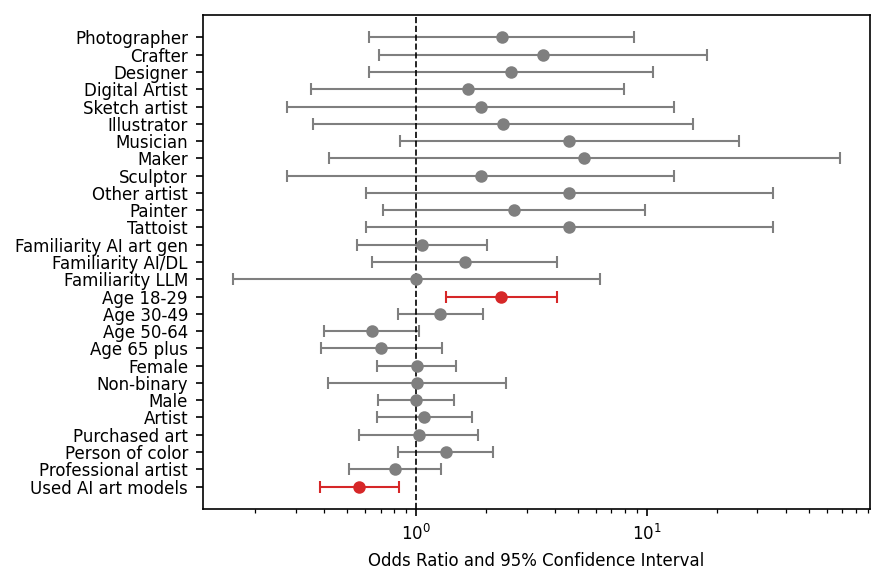

In [301]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)

treeplot(T2W_B_odds.iloc[:5])
treeplot(T2W_GM_odds.iloc[:1])
treeplot(T2W_GNM_odds.iloc[:2])
treeplot(T2W_AgeO_odds.iloc[:2])
treeplot(T2W_AgeY_odds.iloc[:2])
treeplot(T2W_AIfam_odds.iloc[:3])
treeplot(T2W_Artprac_odds.iloc[:12])

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
ax.set_xscale('log')
plt.tight_layout()

In [302]:
T2W_comp_mod_log = OrderedModel(Survey['AI_threat_2art_workers'],
                        Survey[['None, don’t need profit', 'None, donate use of artwork to train models', 'Flat fee',
                                'None, but don’t want for-profit comp to profit', 'None, but don’t want anyone else to profit', 'Not comfortable with any listed',
                                'Portion of any profit from derivatives', 'Portion of any profit from model creators', 'Portion of any profit',
                                'Tax']],
                        distr='logit')

T2W_comp_res_log = T2W_comp_mod_log.fit(method='bfgs', disp=False)
T2W_comp_res_log.summary()

# odds-ratio adjusted standard error
T2W_comp_df2plot = pd.DataFrame({
    'or': np.exp(T2W_comp_res_log.params),
    'var_diag': np.diag(T2W_comp_res_log.cov_params())
})
T2W_comp_df2plot['or_se'] = np.sqrt(T2W_comp_df2plot['or']**2 * T2W_comp_df2plot['var_diag'])
T2W_comp_df2plot = T2W_comp_df2plot.reset_index().rename(columns={'index': 'catego'})

T2W_comp_params = T2W_comp_res_log.params
T2W_comp_conf = T2W_comp_res_log.conf_int()
T2W_comp_conf['Odds Ratio'] = T2W_comp_params
T2W_comp_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
T2W_comp_odds = pd.DataFrame(np.exp(T2W_comp_conf))
# check if pvalues are significant
T2W_comp_odds['pvalues'] = T2W_comp_res_log.pvalues
T2W_comp_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in T2W_comp_res_log.pvalues]
T2W_comp_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
"None, don’t need profit",0.318227,4.551266,1.203467,0.784937,not significant
"None, donate use of artwork to train models",0.366867,3.747900,1.172597,0.788264,not significant
Flat fee,0.492379,5.558458,1.654347,0.415569,not significant
"None, but don’t want for-profit comp to profit",0.672149,6.774345,2.133862,0.198466,not significant
"None, but don’t want anyone else to profit",0.427385,6.406989,1.654767,0.465872,not significant
Not comfortable with any listed,0.880466,11.318314,3.156802,0.077639,not significant
Portion of any profit from derivatives,0.766010,11.308242,2.943165,0.115990,not significant
Portion of any profit from model creators,0.690259,8.054443,2.357891,0.171143,not significant
Portion of any profit,0.416284,5.403195,1.499755,0.535396,not significant
Tax,0.131044,3.680140,0.694450,0.668239,not significant


###plotcomp

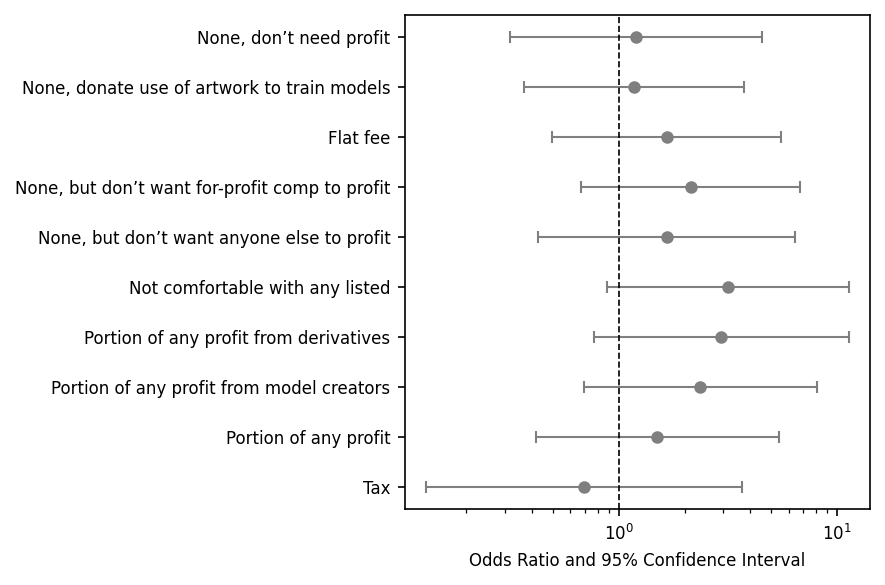

In [303]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)

treeplot(T2W_comp_odds.iloc[:10])

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
ax.set_xscale('log')
plt.tight_layout()


##AI_pos_development_4art

In [304]:
POS_B_mod_log = OrderedModel(Survey['AI_pos_development_4art'],
                        Survey[['Artist', 'Purchased art', 'Person of color', 'Professional artist', 'Used AI art models',
                                ]],
                        distr='logit')

POS_B_res_log = POS_B_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
POS_B_df2plot = pd.DataFrame({
    'or': np.exp(POS_B_res_log.params),
    'var_diag': np.diag(POS_B_res_log.cov_params())
})
POS_B_df2plot['or_se'] = np.sqrt(POS_B_df2plot['or']**2 * POS_B_df2plot['var_diag'])
POS_B_df2plot = POS_B_df2plot.reset_index().rename(columns={'index': 'catego'})

POS_B_params = POS_B_res_log.params
POS_B_conf = POS_B_res_log.conf_int()
POS_B_conf['Odds Ratio'] = POS_B_params
POS_B_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
POS_B_odds = pd.DataFrame(np.exp(POS_B_conf))
# check if pvalues are significant
POS_B_odds['pvalues'] = POS_B_res_log.pvalues
POS_B_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in POS_B_res_log.pvalues]

POS_B_res_log.summary()
POS_B_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Artist,0.364481,0.913316,0.576963,1.893095e-02,significant
Purchased art,0.331723,1.004549,0.577263,5.190669e-02,not significant
Person of color,1.236780,3.085823,1.953582,4.090907e-03,significant
Professional artist,0.840948,2.063429,1.317284,2.287964e-01,not significant
Used AI art models,3.480500,7.703421,5.178007,4.922006e-16,significant
1.0/2.0,0.242648,0.721719,0.418478,1.731787e-03,significant
2.0/3.0,1.135175,1.569220,1.334668,4.742541e-04,significant


In [305]:
POS_GM_mod_log = OrderedModel(Survey['AI_pos_development_4art'],
                        Survey[['Male']],
                        distr='logit')

POS_GM_res_log = POS_GM_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
POS_GM_df2plot = pd.DataFrame({
    'or': np.exp(POS_GM_res_log.params),
    'var_diag': np.diag(POS_GM_res_log.cov_params())
})
POS_GM_df2plot['or_se'] = np.sqrt(POS_GM_df2plot['or']**2 * POS_GM_df2plot['var_diag'])
POS_GM_df2plot = POS_GM_df2plot.reset_index().rename(columns={'index': 'catego'})

POS_GM_params = POS_GM_res_log.params
POS_GM_conf = POS_GM_res_log.conf_int()
POS_GM_conf['Odds Ratio'] = POS_GM_params
POS_GM_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
POS_GM_odds = pd.DataFrame(np.exp(POS_GM_conf))
# check if pvalues are significant
POS_GM_odds['pvalues'] = POS_GM_res_log.pvalues
POS_GM_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in POS_GM_res_log.pvalues]

POS_GM_res_log.summary()
POS_GM_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Male,1.105324,2.232347,1.570817,0.011789,significant
1.0/2.0,0.381210,0.678163,0.508451,0.000004,significant
2.0/3.0,0.985949,1.358272,1.157233,0.073966,not significant


In [306]:
POS_GNM_mod_log = OrderedModel(Survey['AI_pos_development_4art'],
                        Survey[['Female','Non-binary']],
                        distr='logit')

POS_GNM_res_log = POS_GNM_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
POS_GNM_df2plot = pd.DataFrame({
    'or': np.exp(POS_GNM_res_log.params),
    'var_diag': np.diag(POS_GNM_res_log.cov_params())
})
POS_GNM_df2plot['or_se'] = np.sqrt(POS_GNM_df2plot['or']**2 * POS_GNM_df2plot['var_diag'])
POS_GNM_df2plot = POS_GNM_df2plot.reset_index().rename(columns={'index': 'catego'})

POS_GNM_params = POS_GNM_res_log.params
POS_GNM_conf = POS_GNM_res_log.conf_int()
POS_GNM_conf['Odds Ratio'] = POS_GNM_params
POS_GNM_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
POS_GNM_odds = pd.DataFrame(np.exp(POS_GNM_conf))
# check if pvalues are significant
POS_GNM_odds['pvalues'] = POS_GNM_res_log.pvalues
POS_GNM_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in POS_GNM_res_log.pvalues]

POS_GNM_res_log.summary()
POS_GNM_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Female,0.417108,0.868241,0.601789,6.619468e-03,significant
Non-binary,0.420314,2.076117,0.934141,8.672158e-01,not significant
1.0/2.0,0.250377,0.417013,0.323126,3.939256e-18,significant
2.0/3.0,0.988025,1.361231,1.159711,6.989503e-02,not significant


In [307]:
POS_AgeO_mod_log = OrderedModel(Survey['AI_pos_development_4art'],
                        Survey[['Age 50-64','Age 65 plus']],
                        distr='logit')

POS_AgeO_res_log = POS_AgeO_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
POS_AgeO_df2plot = pd.DataFrame({
    'or': np.exp(POS_AgeO_res_log.params),
    'var_diag': np.diag(POS_AgeO_res_log.cov_params())
})
POS_AgeO_df2plot['or_se'] = np.sqrt(POS_AgeO_df2plot['or']**2 * POS_AgeO_df2plot['var_diag'])
POS_AgeO_df2plot = POS_AgeO_df2plot.reset_index().rename(columns={'index': 'catego'})

POS_AgeO_params = POS_AgeO_res_log.params
POS_AgeO_conf = POS_AgeO_res_log.conf_int()
POS_AgeO_conf['Odds Ratio'] = POS_AgeO_params
POS_AgeO_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
POS_AgeO_odds = pd.DataFrame(np.exp(POS_AgeO_conf))
# check if pvalues are significant
POS_AgeO_odds['pvalues'] = POS_AgeO_res_log.pvalues
POS_AgeO_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in POS_AgeO_res_log.pvalues]

POS_AgeO_res_log.summary()
POS_AgeO_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Age 50-64,0.550600,1.369427,0.868336,5.436019e-01,not significant
Age 65 plus,0.346227,1.081700,0.611975,9.107908e-02,not significant
1.0/2.0,0.285580,0.456138,0.360920,1.452458e-17,significant
2.0/3.0,0.980021,1.349903,1.150188,8.672914e-02,not significant


In [308]:
POS_AgeY_mod_log = OrderedModel(Survey['AI_pos_development_4art'],
                        Survey[['Age 18-29','Age 30-49']],
                        distr='logit')

POS_AgeY_res_log = POS_AgeY_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
POS_AgeY_df2plot = pd.DataFrame({
    'or': np.exp(POS_AgeY_res_log.params),
    'var_diag': np.diag(POS_AgeY_res_log.cov_params())
})
POS_AgeY_df2plot['or_se'] = np.sqrt(POS_AgeY_df2plot['or']**2 * POS_AgeY_df2plot['var_diag'])
POS_AgeY_df2plot = POS_AgeY_df2plot.reset_index().rename(columns={'index': 'catego'})

POS_AgeY_params = POS_AgeY_res_log.params
POS_AgeY_conf = POS_AgeY_res_log.conf_int()
POS_AgeY_conf['Odds Ratio'] = POS_AgeY_params
POS_AgeY_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
POS_AgeY_odds = pd.DataFrame(np.exp(POS_AgeY_conf))
# check if pvalues are significant
POS_AgeY_odds['pvalues'] = POS_AgeY_res_log.pvalues
POS_AgeY_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in POS_AgeY_res_log.pvalues]

POS_AgeY_res_log.summary()
POS_AgeY_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Age 18-29,0.563970,1.493795,0.917854,0.730133,not significant
Age 30-49,1.022423,2.304733,1.535061,0.038743,significant
1.0/2.0,0.335192,0.660937,0.470681,0.000014,significant
2.0/3.0,0.987347,1.360207,1.158877,0.071206,not significant


In [309]:
POS_AIfam_mod_log = OrderedModel(Survey['AI_pos_development_4art'],
                        Survey[['Familiarity AI art gen',
                                'Familiarity AI/DL',
                                'Familiarity LLM',
                                'Familiarity text to image']],
                        distr='logit')

POS_AIfam_res_log = POS_AIfam_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
POS_AIfam_df2plot = pd.DataFrame({
    'or': np.exp(POS_AIfam_res_log.params),
    'var_diag': np.diag(POS_AIfam_res_log.cov_params())
})
POS_AIfam_df2plot['or_se'] = np.sqrt(POS_AIfam_df2plot['or']**2 * POS_AIfam_df2plot['var_diag'])
POS_AIfam_df2plot = POS_AIfam_df2plot.reset_index().rename(columns={'index': 'catego'})

POS_AIfam_params = POS_AIfam_res_log.params
POS_AIfam_conf = POS_AIfam_res_log.conf_int()
POS_AIfam_conf['Odds Ratio'] = POS_AIfam_params
POS_AIfam_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
POS_AIfam_odds = pd.DataFrame(np.exp(POS_AIfam_conf))
# check if pvalues are significant
POS_AIfam_odds['pvalues'] = POS_AIfam_res_log.pvalues
POS_AIfam_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in POS_AIfam_res_log.pvalues]

POS_AIfam_res_log.summary()
POS_AIfam_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Familiarity AI art gen,0.594964,1.937282,1.073598,0.813584,not significant
Familiarity AI/DL,0.460722,2.345589,1.039551,0.925566,not significant
Familiarity LLM,0.185243,8.879363,1.282512,0.801008,not significant
Familiarity text to image,0.256932,3.219854,0.909550,0.883141,not significant
1.0/2.0,0.234822,0.732009,0.414599,0.002401,significant
2.0/3.0,0.975035,1.342817,1.144244,0.098879,not significant


In [310]:
POS_Artprac_mod_log = OrderedModel(Survey['AI_pos_development_4art'],
                        Survey[['Photographer', 'Crafter', 'Designer',
                                'Digital Artist', 'Sketch artist', 'Illustrator',
                                'Musician',
                                'Maker',
                                'Sculptor',
                                'Other artist', 'Painter',
                                'Tattoist', 'Writer']],
                        distr='logit')

POS_Artprac_res_log = POS_Artprac_mod_log.fit(method='bfgs', disp=False)

# odds-ratio adjusted standard error
POS_Artprac_df2plot = pd.DataFrame({
    'or': np.exp(POS_Artprac_res_log.params),
    'var_diag': np.diag(POS_Artprac_res_log.cov_params())
})
POS_Artprac_df2plot['or_se'] = np.sqrt(POS_Artprac_df2plot['or']**2 * POS_Artprac_df2plot['var_diag'])
POS_Artprac_df2plot = POS_Artprac_df2plot.reset_index().rename(columns={'index': 'catego'})

POS_Artprac_params = POS_Artprac_res_log.params
POS_Artprac_conf = POS_Artprac_res_log.conf_int()
POS_Artprac_conf['Odds Ratio'] = POS_Artprac_params
POS_Artprac_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
POS_Artprac_odds = pd.DataFrame(np.exp(POS_Artprac_conf))
# check if pvalues are significant
POS_Artprac_odds['pvalues'] = POS_Artprac_res_log.pvalues
POS_Artprac_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in POS_Artprac_res_log.pvalues]

POS_Artprac_res_log.summary()
POS_Artprac_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
Photographer,0.267789,3.763090,1.003849,0.995454,not significant
Crafter,0.059216,1.147651,0.260691,0.075429,not significant
Designer,0.203683,3.386843,0.830568,0.795733,not significant
Digital Artist,0.126946,2.668446,0.582021,0.486019,not significant
Sketch artist,0.222575,9.567887,1.459305,0.693624,not significant
Illustrator,0.100764,3.509196,0.594644,0.566036,not significant
Musician,0.111120,2.489955,0.526007,0.417996,not significant
Maker,0.005815,0.967095,0.074991,0.047077,significant
Sculptor,0.016156,1.091709,0.132805,0.060336,not significant
Other artist,0.100764,3.509204,0.594644,0.566036,not significant


###plot

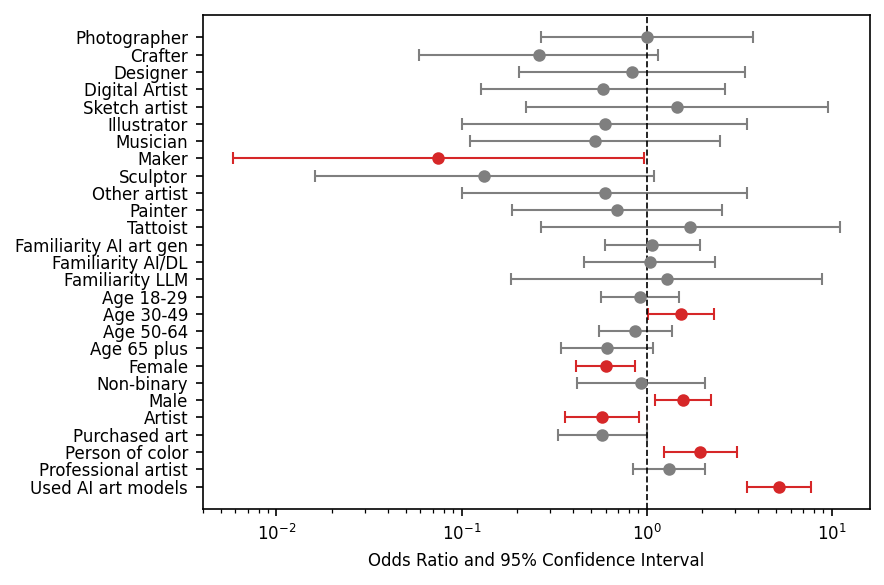

In [311]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)

treeplot(POS_B_odds.iloc[:5])
treeplot(POS_GM_odds.iloc[:1])
treeplot(POS_GNM_odds.iloc[:2])
treeplot(POS_AgeO_odds.iloc[:2])
treeplot(POS_AgeY_odds.iloc[:2])
treeplot(POS_AIfam_odds.iloc[:3])
treeplot(POS_Artprac_odds.iloc[:12])

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
ax.set_xscale('log')
plt.tight_layout()

###plotcomp

In [312]:
POS_comp_mod_log = OrderedModel(Survey['AI_pos_development_4art'],
                        Survey[['None, don’t need profit', 'None, donate use of artwork to train models', 'Flat fee',
                                'None, but don’t want for-profit comp to profit', 'None, but don’t want anyone else to profit', 'Not comfortable with any listed',
                                'Portion of any profit from derivatives', 'Portion of any profit from model creators', 'Portion of any profit',
                                'Tax']],
                        distr='logit')

POS_comp_res_log = POS_comp_mod_log.fit(method='bfgs', disp=False)
# odds-ratio adjusted standard error
POS_comp_df2plot = pd.DataFrame({
    'or': np.exp(POS_comp_res_log.params),
    'var_diag': np.diag(POS_comp_res_log.cov_params())
})
POS_comp_df2plot['or_se'] = np.sqrt(POS_comp_df2plot['or']**2 * POS_comp_df2plot['var_diag'])
POS_comp_df2plot = POS_comp_df2plot.reset_index().rename(columns={'index': 'catego'})

POS_comp_params = POS_comp_res_log.params
POS_comp_conf = POS_comp_res_log.conf_int()
POS_comp_conf['Odds Ratio'] = POS_comp_params
POS_comp_conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert coef to Odds Ratios
POS_comp_odds = pd.DataFrame(np.exp(POS_comp_conf))
# check if pvalues are significant
POS_comp_odds['pvalues'] = POS_comp_res_log.pvalues
POS_comp_odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in POS_comp_res_log.pvalues]

POS_comp_odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
"None, don’t need profit",0.779115,12.922381,3.173015,0.107049,not significant
"None, donate use of artwork to train models",4.162129,57.308125,15.444217,0.000043,significant
Flat fee,0.445466,5.012977,1.494360,0.515373,not significant
"None, but don’t want for-profit comp to profit",0.305542,3.134003,0.978555,0.970882,not significant
"None, but don’t want anyone else to profit",0.387164,5.704167,1.486085,0.563771,not significant
Not comfortable with any listed,0.093500,1.160233,0.329365,0.083874,not significant
Portion of any profit from derivatives,0.296462,3.932296,1.079711,0.907418,not significant
Portion of any profit from model creators,0.295023,3.389090,0.999929,0.999909,not significant
Portion of any profit,0.319872,4.208076,1.160191,0.821179,not significant
Tax,0.327069,13.554205,2.105507,0.433234,not significant


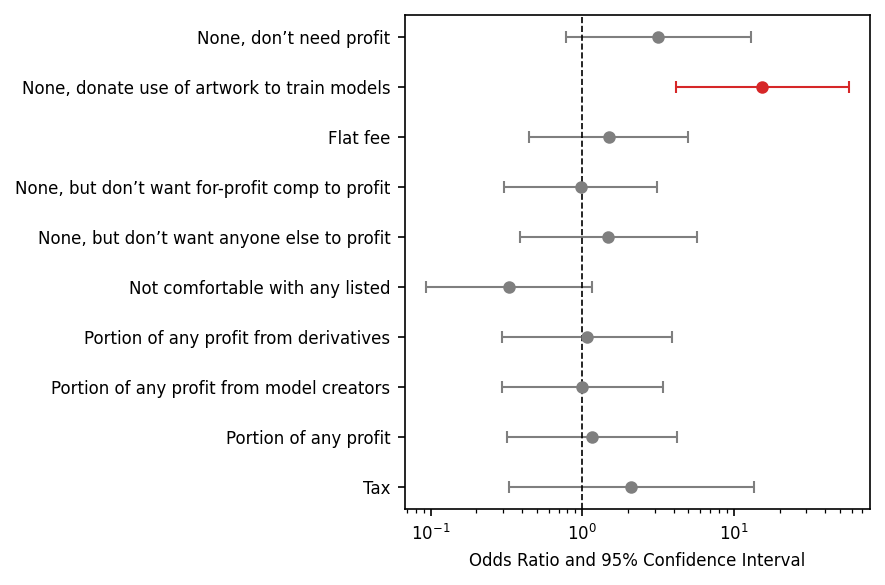

In [313]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)

treeplot(POS_comp_odds.iloc[:10])

plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
ax.set_xscale('log')
plt.tight_layout()
